In [1]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

# OPV NN2

### This notebook to uses all tabular OPV processing conditions and morphological descriptors to predict device performance.


# Dataset definition

In [2]:
#Take in data as a dataframe for easy preprocessing
total_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_train.xlsx')

test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

print (f'total_df shape: {total_df.shape}')
print (f'test_df shape: {test_df.shape}')
total_df.head()

total_df shape: (26, 60)
test_df shape: (10, 60)


Unnamed: 0  p1_fraction  p2_fraction  p3_fraction  p1_area_avg  \
0           0     0.379892     0.741510     0.042227     0.747318   
1           1     0.299771     0.662438     0.354767     0.338403   
2           2     0.122273     0.555842     0.907236     0.637064   
3           3     0.019406     0.848362     0.504491     0.832873   
4           6     1.000000     0.000000     0.384999     0.271485   

   p1_area_stdev  p1_filled_area_avg  p1_filled_area_stdev  p1_extent_avg  \
0       0.416992            0.747056              0.437669       0.371252   
1       0.119074            0.308619              0.108677       0.427280   
2       0.178141            0.581681              0.158955       0.172276   
3       0.498779            0.868876              0.509000       0.240255   
4       0.175114            0.267725              0.171034       0.309962   

   p1_extent_stdev  ...  p3_Perim_avg  p3_Perim_stdev       PCE      VocL  \
0         0.265335  ...      0.385802        0.214615  0.833110  0.817731   
1         0.413324  ...      0.756401        0.786992  0.635534  0.739614   
2         0.278782  ...      0.771184        1.000000  0.863038  0.814898   
3         0.557641  ...      0.557095        0.404926  0.947300  0.806031   
4         0.288716  ...      0.000000        0.084425  0.865331  0.825047   

        Jsc        FF  Substrate  Device  Anneal_time  Anneal_temp  
0  0.950302  0.822343          4       2           15          100  
1  0.961763  0.685312          4       4           15          100  
2  0.947029  0.857800          4       7           15          100  
3  0.996387  0.904754          7       2           30          100  
4  0.903792  0.890140          1       3            5          100  

[5 rows x 60 columns]

In [3]:
# Hyper parameters
batch_size = int(len(total_df['PCE']) * 0.9) # 90% of x_train samples

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
y_train = total_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted
x_train = total_df.drop(['PCE', 'VocL', 'Jsc', 'FF'], axis = 1)

y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]
x_test = test_df.drop(['PCE', 'VocL', 'Jsc', 'FF'], axis = 1)

In [5]:
pce_train = y_train['PCE']
pce_test = y_test['PCE']
voc_train = y_train['VocL']
voc_test = y_test['VocL']
jsc_train = y_train['Jsc']
jsc_test = y_test['Jsc']
ff_train = y_train['FF']
ff_test = y_test['FF']

In [6]:
x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))
voc_train_tensor = torch.tensor(voc_train.values.astype(np.float32))
jsc_train_tensor = torch.tensor(jsc_train.values.astype(np.float32))
ff_train_tensor = torch.tensor(ff_train.values.astype(np.float32))

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor, voc_train_tensor, jsc_train_tensor, ff_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))
voc_test_tensor = torch.tensor(voc_test.values.astype(np.float32))
jsc_test_tensor = torch.tensor(jsc_test.values.astype(np.float32))
ff_test_tensor = torch.tensor(ff_test.values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor, voc_test_tensor, jsc_test_tensor, ff_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = 10, shuffle = False)

# Fit model with variety of learning rates and epochs to find best hyperparameters

In [70]:
%autoreload

def fit(model, lr, epochs):
    """
    
    """
    #define the optimizer
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    
    #empty list to hold loss per epoch
    train_epoch_losses = []
    pce_train_epoch_losses = []
    voc_train_epoch_losses = []
    jsc_train_epoch_losses = []
    ff_train_epoch_losses = []

    test_epoch_losses = []
    pce_test_epoch_losses = []
    voc_test_epoch_losses = []
    jsc_test_epoch_losses = []
    ff_test_epoch_losses = []

    pce_test_epoch_accuracies = []
    voc_test_epoch_accuracies = []
    jsc_test_epoch_accuracies = []
    ff_test_epoch_accuracies = []
    test_epoch_accuracies = []

    pce_test_epoch_r2 = []
    voc_test_epoch_r2 = []
    jsc_test_epoch_r2 = []
    ff_test_epoch_r2 = []
    test_epoch_r2s = []

    save_epochs = np.arange(0, num_epochs, 5)

    for epoch in range(epochs):
        print('On epoch ', epoch)

    #     save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN2/"
    #     model_name = "OPV_NN2"
    #     model_path = save_dir+model_name+'*.pt'
    #     if epoch < 10:
    #         save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    #     else:
    #         save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'

    #     if glob.glob(model_path) != []:
    #         model_states = glob.glob(model_path)
    #         model_states = sorted(model_states)
    #         previous_model = model_states[-1]    

    #         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)

        model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,                                                                                                     training_data_set = training_data_set,
                                                                                                             optimizer = optimizer)
        train_epoch_losses.append(train_loss)
        pce_train_epoch_losses.append(pce_train_loss)
        voc_train_epoch_losses.append(voc_train_loss)
        jsc_train_epoch_losses.append(jsc_train_loss)
        ff_train_epoch_losses.append(ff_train_loss)

        test_losses, test_accs, test_r2s = test.eval_OPV_df_model(model = model,
                                                                  testing_data_set = testing_data_set)
        pce_test_epoch_losses.append(test_losses[0])
        voc_test_epoch_losses.append(test_losses[1])
        jsc_test_epoch_losses.append(test_losses[2])
        ff_test_epoch_losses.append(test_losses[3])

        tot_tst_loss = sum(test_losses)
        test_epoch_losses.append(tot_tst_loss)

        pce_test_epoch_accuracies.append(test_accs[0])
        voc_test_epoch_accuracies.append(test_accs[1])
        jsc_test_epoch_accuracies.append(test_accs[2])
        ff_test_epoch_accuracies.append(test_accs[3])

        tot_tst_acc = sum(test_accs)
        test_epoch_accuracies.append(tot_tst_acc)

        pce_test_epoch_r2.append(test_r2s[0])
        voc_test_epoch_r2.append(test_r2s[1])
        jsc_test_epoch_r2.append(test_r2s[2])
        ff_test_epoch_r2.append(test_r2s[3])

        tot_tst_r2 = sum(test_r2s)
        test_epoch_r2s.append(tot_tst_r2)

        #nuts.save_trained_model(save_path, epoch, model, optimizer)
        
        print('Finished epoch ', epoch)
        
    best_loss_indx = test_epoch_losses.index(min(test_epoch_losses))
    best_acc_indx = test_epoch_accuracies.index(min(test_epoch_accuracies))
    best_r2_indx = test_epoch_r2s.index(max(test_epoch_r2s))
    
    fit_results = {
        'lr': lr,
        'best_loss_epoch': best_loss_indx,
        'best_acc_epoch': best_acc_indx,
        'best_r2_epoch': best_r2_indx,
        'pce_loss': pce_test_epoch_losses,
        'voc_loss': voc_test_epoch_losses,
        'jsc_loss': jsc_test_epoch_losses,
        'ff_loss': ff_test_epoch_losses,
        'test_losses': test_epoch_losses,        
        'pce_acc': pce_test_epoch_accuracies,
        'voc_acc': voc_test_epoch_accuracies,
        'jsc_acc': jsc_test_epoch_accuracies,
        'ff_acc': ff_test_epoch_accuracies,
        'test_accs': test_epoch_accuracies,
        'pce_r2': pce_test_epoch_r2,
        'voc_r2': voc_test_epoch_r2,
        'jsc_r2': jsc_test_epoch_r2,
        'ff_r2': ff_test_epoch_r2,
        'test_r2s': test_epoch_r2s,
        'train_pce_loss': pce_train_epoch_losses,
        'train_voc_loss': voc_train_epoch_losses,
        'train_jsc_loss': jsc_train_epoch_losses,
        'train_ff_loss': ff_train_epoch_losses
    }

    return fit_results
    

# Initialize model 

In [8]:
# takes in 8 features (anneal time, anneal temp, MajorAL, MinorAL, Ecc, Orient, Perim, GMM_label) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
model.apply(nuts.init_weights)
# print(model)

OPV_df_NN(
  (em_layer): Sequential(
    (0): Linear(in_features=56, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
  )
  (PCE_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=500, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): ReLU()
  )
  (Voc_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=500, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): ReLU()
  )
  (Jsc_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=500, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, 

In [9]:
%autoreload

lrs = np.linspace(3e-3, 1e-2, 50)

lr_opt = {}

for i, lr in enumerate(lrs):
    print(f'  optimization loop {i}')
    print('-----------------------------')
    
    lr_opt[i] = fit(model, lr, epochs = 30)


  optimization loop 0
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 882.5968017578125
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 150.80654907226562
                              FF = 255.42037963867188
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 94.8721923828125
                              FF = 33.571678161621094
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 94.57441711425781
                              FF = 95.51933288574219
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 99.47816467285156
                              Jsc = 70.23006439208984
                              FF = 100.0
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 95.28858184814453
                              Voc = 78.91036224365234
                              Jsc = 32.256500244140625
                              FF = 100.0
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 84.55521392822266
                              Voc = 65.32096862792969
                              Jsc = 21.59017562866211
                              FF = 100.0
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 98.99148559570312
                              Voc = 59.498477935791016
                              Jsc = 19.879791259765625
                              FF = 93.54240417480469
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 95.20275115966797
                          

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 28.710573196411133
                              Jsc = 52.579193115234375
                              FF = 68.40913391113281
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 30.671899795532227
                              Jsc = 52.948631286621094
                              FF = 67.29975128173828
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 40.03446960449219
                              Jsc = 51.33122634887695
                              FF = 79.43448638916016
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 60.616336822509766
                              Jsc = 52.719093322753906
                              FF = 82.4098892211914
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 100.0
                              Voc

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 57.643802642822266
                              Voc = 32.99309158325195
                              Jsc = 35.75232696533203
                              FF = 90.69487762451172
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 60.513126373291016
                              Voc = 31.944202423095703
                              Jsc = 32.59095764160156
                              FF = 84.64154052734375
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 56.64835739135742
                              Voc = 33.6744499206543
                              Jsc = 29.713157653808594
                              FF = 75.94281768798828
Finished epoch  29
  optimization loop 1
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 56.33696365356445
                              Voc = 87.4281997680664
                              Jsc = 59.249813079833984
                              FF = 95.98200988769531
Finish

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 190.55967712402344
                              Voc = 93.61871337890625
                              Jsc = 97.75289154052734
                              FF = 36.14348602294922
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 193.75439453125
                              Voc = 97.49862670898438
                              Jsc = 100.0
                              FF = 30.63248062133789
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 147.75245666503906
                              Voc = 94.80047607421875
                              Jsc = 100.0
                              FF = 23.619205474853516
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 115.88885498046875
                              Voc = 97.71006774902344
                              Jsc = 100.0
                              FF = 30.734634399414062
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 103.59523010253906
                  

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 90.21159362792969
                              Voc = 48.72358322143555
                              Jsc = 100.0
                              FF = 53.92182540893555
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 99.36979675292969
                              Voc = 7.758764743804932
                              Jsc = 100.0
                              FF = 28.415935516357422
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 39.56086730957031
                              Jsc = 100.0
                              FF = 10.745503425598145
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 69.3122787475586
                              Jsc = 100.0
                              FF = 11.78759479522705
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 78.85346221923828
       

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 21.606544494628906
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 24.008235931396484
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 29.323036193847656
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 26.223876953125
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 31.936954498291016
                              Jsc = 100.0
                              FF = 1

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 10

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 94.34528350830078
Finished epoch  20
On epoch  21
Total Epoch T

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 26.522653579711914
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 24.175703048706055
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 15.561421394348145
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 15.044525146484375
Finished epoch  29
  optimization loop 3
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 1

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  29
  optimization loop 4
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epo

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 98.70748901367188
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 83.93724822998047
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 56.55964660644531
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  5
On epoch  6

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 37.84489440917969
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 35.366817474365234
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 27.277362823486328
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 21.44426155090332
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 20.906896591186523
                              Jsc = 100.0
                              FF = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 34.98245620727539
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 29.92483901977539
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 45.73964309692383
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 60.06315994262695
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 73.07976531982422
                              Jsc = 100.0
                              FF = 100

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 95.97564697265625
                              FF = 100.0
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 91.06391906738281
                              FF = 100.0
Finished epoch  5
On epoch  6
Total Epoch

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 82.42572784423828
                              FF = 100.0
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 83.61528778076172
                              FF = 100.0
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 87.84358978271484
                              FF = 100.0
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 91.29054260253906
                              FF = 100.0
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 92.73822021484375
                              FF = 100

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 91.18733215332031
                              FF = 100.0
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 87.3520278930664
                              FF = 100.0
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 82.69306182861328
                              FF = 100.0
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 76.06605529785156
                              FF = 100.0
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 74.1082992553711
                              FF = 100.0

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 74.45930480957031
                              FF = 100.0
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 75.47600555419922
                              FF = 100.0
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 74.79126739501953
                              FF = 100.0
Finished epoch  29
  optimization loop 7
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 95.42015075683594
                              FF = 100.0
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 100.0
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 99.45238494873047
                              Jsc = 99.32498931884766
                              FF = 100.0
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 98.36517333984375
                              Jsc = 95.26020812988281
                              FF = 100.0
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 95.39567565917969
                              Jsc = 89.3553466796875
                              FF

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 92.52668762207031
                              Jsc = 49.175209045410156
                              FF = 99.75993347167969
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 96.13188171386719
                              Jsc = 63.27241516113281
                              FF = 99.66970825195312
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 96.7000961303711
                              Jsc = 73.01286315917969
                              FF = 99.39224243164062
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 96.51815032958984
                              Jsc = 83.86150360107422
                              FF = 99.41117095947266
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 97

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 97.41481018066406
                              Jsc = 95.64521789550781
                              FF = 98.85862731933594
Finished epoch  29
  optimization loop 8
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 95.6133041381836
                              Jsc = 91.19928741455078
                              FF = 99.19551849365234
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 74.61933135986328
                              Jsc = 76.42867279052734
                              FF = 91.04090881347656
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 66.62713623046875
                              Jsc = 83.05416107177734
                              FF = 86.77350616455078
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 50.347625732421875
                              Jsc = 36.54715347290039
                              FF = 81.7803955078125
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 48.365989685058594
                              Jsc = 36.171810150146484
                              FF = 83.35944366455078
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 45.496707916259766
                              Jsc = 36.375736236572266
                              FF = 84.01771545410156
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 44.05213165283203
                              Jsc = 36.46486282348633
                              FF = 87.04129791259766
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 100.0
                              Voc 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 52.747440338134766
                              Jsc = 32.125186920166016
                              FF = 83.15841674804688
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 51.23571014404297
                              Jsc = 31.73252296447754
                              FF = 81.59207153320312
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 50.659393310546875
                              Jsc = 31.444988250732422
                              FF = 78.92453002929688
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 49.9835090637207
                              Jsc = 31.78076171875
                              FF = 76.9702377319336
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 100.0
                              Voc = 51.

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 75.8824234008789
                              Voc = 23.026987075805664
                              Jsc = 28.0968017578125
                              FF = 61.14280700683594
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 86.77394104003906
                              Voc = 17.74715232849121
                              Jsc = 30.446752548217773
                              FF = 65.18582153320312
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 89.45848083496094
                              Voc = 18.440895080566406
                              Jsc = 33.237831115722656
                              FF = 66.19757080078125
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 87.70066833496094
                              Voc = 25.269174575805664
                              Jsc = 34.51836013793945
                              FF = 65.24339294433594
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 8

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 43.0914306640625
                              Voc = 20.204362869262695
                              Jsc = 48.787261962890625
                              FF = 40.17051696777344
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 43.6962776184082
                              Voc = 12.845453262329102
                              Jsc = 53.05141830444336
                              FF = 38.67952346801758
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 45.97815704345703
                              Voc = 5.299155235290527
                              Jsc = 56.98283386230469
                              FF = 37.8191032409668
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 48.6620979309082
                              Voc = 2.325105905532837
                              Jsc = 61.919189453125
                              FF = 35.9943962097168
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 48.02850341796875
                              Voc = 96.0316162109375
                              Jsc = 69.99332427978516
                              FF = 23.902528762817383
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 48.814659118652344
                              Voc = 105.22848510742188
                              Jsc = 69.4774169921875
                              FF = 25.75339698791504
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 50.979530334472656
                              Voc = 112.1811752319336
                              Jsc = 69.8284912109375
                              FF = 28.16582679748535
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 53.29560089111328
                              Voc = 116.2150650024414
                              Jsc = 69.14974212646484
                              FF = 30.057283401489258
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 65.05029296875
                              Voc = 174.12197875976562
                              Jsc = 82.99748229980469
                              FF = 16.622360229492188
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 64.55091857910156
                              Voc = 171.36878967285156
                              Jsc = 89.1935043334961
                              FF = 23.461536407470703
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 62.597190856933594
                              Voc = 164.55694580078125
                              Jsc = 87.89812469482422
                              FF = 32.99930191040039
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 58.40512466430664
                              Voc = 157.7837677001953
                              Jsc = 79.28063201904297
                              FF = 40.13562774658203
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 55

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 55.51913833618164
                              Voc = 97.57093048095703
                              Jsc = 38.59318923950195
                              FF = 60.225711822509766
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 53.68707275390625
                              Voc = 92.6577377319336
                              Jsc = 38.3918571472168
                              FF = 56.223785400390625
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 54.807735443115234
                              Voc = 88.78144836425781
                              Jsc = 35.510746002197266
                              FF = 54.21438217163086
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 54.18268585205078
                              Voc = 88.05243682861328
                              Jsc = 34.68404769897461
                              FF = 51.05167770385742
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 54.12799072265625
                              Voc = 75.35679626464844
                              Jsc = 33.90615463256836
                              FF = 32.03131103515625
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 54.243839263916016
                              Voc = 72.71577453613281
                              Jsc = 32.38822937011719
                              FF = 32.59734344482422
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 55.074180603027344
                              Voc = 69.9612045288086
                              Jsc = 31.956920623779297
                              FF = 33.917911529541016
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 53.73171615600586
                              Voc = 65.79324340820312
                              Jsc = 28.90287971496582
                              FF = 34.03413391113281
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 41.53838348388672
                              Voc = 50.121150970458984
                              Jsc = 20.821699142456055
                              FF = 15.64003849029541
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 38.08507537841797
                              Voc = 52.90924835205078
                              Jsc = 18.26402473449707
                              FF = 15.68471908569336
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 36.46139907836914
                              Voc = 56.64662551879883
                              Jsc = 17.667686462402344
                              FF = 16.063024520874023
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 35.7840576171875
                              Voc = 57.71120834350586
                              Jsc = 17.589893341064453
                              FF = 16.033926010131836
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 25.9248104095459
                              Voc = 73.30126190185547
                              Jsc = 35.71880340576172
                              FF = 14.705955505371094
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 25.894466400146484
                              Voc = 77.7464828491211
                              Jsc = 33.746543884277344
                              FF = 14.901677131652832
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 26.0100154876709
                              Voc = 83.43962097167969
                              Jsc = 35.2641487121582
                              FF = 15.00370979309082
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 25.484338760375977
                              Voc = 87.30088806152344
                              Jsc = 34.49993896484375
                              FF = 15.23173713684082
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 25.71586036682129
                              Voc = 88.58232116699219
                              Jsc = 44.31706237792969
                              FF = 15.49722957611084
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 26.36072540283203
                              Voc = 89.28182983398438
                              Jsc = 42.861167907714844
                              FF = 15.448472023010254
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 27.409133911132812
                              Voc = 89.8079605102539
                              Jsc = 43.04044723510742
                              FF = 15.398446083068848
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 27.73129653930664
                              Voc = 89.66997528076172
                              Jsc = 42.42106246948242
                              FF = 15.403940200805664
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 31.68423843383789
                              Voc = 71.84027099609375
                              Jsc = 33.60107421875
                              FF = 17.197744369506836
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 31.403940200805664
                              Voc = 81.73004913330078
                              Jsc = 37.4598503112793
                              FF = 16.46014976501465
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 31.656494140625
                              Voc = 92.96614837646484
                              Jsc = 42.0765495300293
                              FF = 15.812817573547363
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 30.46877098083496
                              Voc = 94.11195373535156
                              Jsc = 41.53521728515625
                              FF = 16.064712524414062
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 27.5122

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 22.84729766845703
                              Voc = 55.58451461791992
                              Jsc = 30.31160545349121
                              FF = 14.532001495361328
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 22.089176177978516
                              Voc = 57.60181427001953
                              Jsc = 33.96169662475586
                              FF = 14.543357849121094
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 22.025373458862305
                              Voc = 58.75375747680664
                              Jsc = 36.825496673583984
                              FF = 14.581331253051758
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 22.14369010925293
                              Voc = 60.785491943359375
                              Jsc = 38.05610656738281
                              FF = 14.605805397033691
Finished epoch  18
On epoch  19
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 22.730628967285156
                              Voc = 64.00862121582031
                              Jsc = 28.665616989135742
                              FF = 14.968356132507324
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 22.817785263061523
                              Voc = 65.39682006835938
                              Jsc = 30.481019973754883
                              FF = 15.120119094848633
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 22.818283081054688
                              Voc = 65.8823471069336
                              Jsc = 32.6434211730957
                              FF = 15.20196533203125
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 22.79901123046875
                              Voc = 63.96681213378906
                              Jsc = 33.37839126586914
                              FF = 15.34006404876709
Finished epoch  28
On epoch  29
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 21.742366790771484
                              Voc = 62.96272277832031
                              Jsc = 43.493228912353516
                              FF = 14.679068565368652
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 21.47467041015625
                              Voc = 59.95478820800781
                              Jsc = 36.011878967285156
                              FF = 14.872283935546875
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 21.797502517700195
                              Voc = 57.79732894897461
                              Jsc = 27.920665740966797
                              FF = 15.122196197509766
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 22.175249099731445
                              Voc = 56.13278579711914
                              Jsc = 23.969802856445312
                              FF = 15.128472328186035
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 20.960262298583984
                              Voc = 82.39952850341797
                              Jsc = 29.918336868286133
                              FF = 12.62792682647705
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 20.80457878112793
                              Voc = 83.94989776611328
                              Jsc = 30.68333625793457
                              FF = 12.665921211242676
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 20.599708557128906
                              Voc = 80.1363296508789
                              Jsc = 29.176923751831055
                              FF = 12.571805953979492
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 20.438047409057617
                              Voc = 77.049072265625
                              Jsc = 29.007402420043945
                              FF = 12.406569480895996
Finished epoch  18
On epoch  19
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 20.9100341796875
                              Voc = 77.61763763427734
                              Jsc = 31.5152587890625
                              FF = 12.482277870178223
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 20.946935653686523
                              Voc = 76.65807342529297
                              Jsc = 34.61296081542969
                              FF = 12.499435424804688
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 20.91016387939453
                              Voc = 72.36405181884766
                              Jsc = 36.56639862060547
                              FF = 12.427574157714844
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 20.933856964111328
                              Voc = 70.01348114013672
                              Jsc = 35.88615798950195
                              FF = 12.418808937072754
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 21.597558975219727
                              Voc = 40.93842315673828
                              Jsc = 48.02028274536133
                              FF = 12.986722946166992
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 21.80086898803711
                              Voc = 49.3986930847168
                              Jsc = 44.87188720703125
                              FF = 13.303789138793945
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 21.975528717041016
                              Voc = 54.793827056884766
                              Jsc = 43.81389617919922
                              FF = 13.400184631347656
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 21.985185623168945
                              Voc = 56.033687591552734
                              Jsc = 42.81808853149414
                              FF = 13.113443374633789
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 22.040359497070312
                              Voc = 31.83392333984375
                              Jsc = 38.972206115722656
                              FF = 13.525432586669922
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 22.099388122558594
                              Voc = 36.708221435546875
                              Jsc = 38.86719512939453
                              FF = 13.413052558898926
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 22.2934513092041
                              Voc = 39.270816802978516
                              Jsc = 39.4780387878418
                              FF = 13.3151273727417
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 22.436063766479492
                              Voc = 42.59751892089844
                              Jsc = 40.17280197143555
                              FF = 13.413439750671387
Finished epoch  17
On epoch  18
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 23.666553497314453
                              Voc = 35.677001953125
                              Jsc = 31.98750877380371
                              FF = 13.82912540435791
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 23.69484519958496
                              Voc = 36.287696838378906
                              Jsc = 32.398048400878906
                              FF = 13.844850540161133
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 23.669546127319336
                              Voc = 37.66674041748047
                              Jsc = 31.116792678833008
                              FF = 13.850966453552246
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 23.6258544921875
                              Voc = 39.66028594970703
                              Jsc = 30.864652633666992
                              FF = 13.910724639892578
Finished epoch  28
On epoch  29
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 26.789751052856445
                              Voc = 13.85146713256836
                              Jsc = 28.12803077697754
                              FF = 12.44628620147705
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 26.242795944213867
                              Voc = 18.721702575683594
                              Jsc = 29.391510009765625
                              FF = 12.269822120666504
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 25.42642593383789
                              Voc = 27.168041229248047
                              Jsc = 29.865962982177734
                              FF = 12.043313026428223
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 24.254304885864258
                              Voc = 37.9997673034668
                              Jsc = 32.755096435546875
                              FF = 11.863737106323242
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 28.452051162719727
                              Voc = 42.36369323730469
                              Jsc = 68.44599914550781
                              FF = 13.936885833740234
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 33.05295944213867
                              Voc = 33.19551086425781
                              Jsc = 72.92637634277344
                              FF = 14.672719955444336
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 36.776241302490234
                              Voc = 23.68494987487793
                              Jsc = 73.97167205810547
                              FF = 15.115094184875488
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 37.22651672363281
                              Voc = 17.114919662475586
                              Jsc = 74.0580825805664
                              FF = 14.457305908203125
Finished epoch  18
On epoch  19
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 34.311038970947266
                              Voc = 43.99012756347656
                              Jsc = 102.63353729248047
                              FF = 24.07305908203125
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 35.50297546386719
                              Voc = 44.12620162963867
                              Jsc = 106.3094711303711
                              FF = 26.046913146972656
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 36.114078521728516
                              Voc = 46.12578582763672
                              Jsc = 107.1478271484375
                              FF = 28.04474449157715
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 37.832393646240234
                              Voc = 46.12093734741211
                              Jsc = 107.65043640136719
                              FF = 28.259164810180664
Finished epoch  29
  optimization loop 16
-----------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 23.651453018188477
                              Voc = 41.89140319824219
                              Jsc = 63.43673324584961
                              FF = 16.28471565246582
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 23.545856475830078
                              Voc = 49.903202056884766
                              Jsc = 67.95691680908203
                              FF = 15.641803741455078
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 23.08785057067871
                              Voc = 55.131309509277344
                              Jsc = 71.79573822021484
                              FF = 14.907958984375
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 22.667617797851562
                              Voc = 65.11644744873047
                              Jsc = 64.16413116455078
                              FF = 12.459192276000977
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 22.30448341369629
                              Voc = 63.111488342285156
                              Jsc = 29.789113998413086
                              FF = 12.408836364746094
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 22.47727394104004
                              Voc = 62.20627975463867
                              Jsc = 29.931535720825195
                              FF = 12.408315658569336
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 22.412296295166016
                              Voc = 62.21686553955078
                              Jsc = 29.33287239074707
                              FF = 12.379426956176758
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 22.20983123779297
                              Voc = 58.46572494506836
                              Jsc = 26.14324188232422
                              FF = 12.342621803283691
Finished epoch  19
On epoch  20
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 21.60232162475586
                              Voc = 39.88241195678711
                              Jsc = 22.208478927612305
                              FF = 12.264082908630371
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 21.64472770690918
                              Voc = 37.34894561767578
                              Jsc = 23.087669372558594
                              FF = 12.250544548034668
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 21.65030288696289
                              Voc = 38.06428146362305
                              Jsc = 22.674760818481445
                              FF = 12.251154899597168
Finished epoch  29
  optimization loop 17
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 21.854522705078125
                              Voc = 14.966650009155273
                              Jsc = 25.006628036499023
                              FF = 16.91396713256836

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 21.1592960357666
                              Voc = 15.544840812683105
                              Jsc = 15.123605728149414
                              FF = 12.367208480834961
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 21.067142486572266
                              Voc = 15.221063613891602
                              Jsc = 15.275081634521484
                              FF = 13.529775619506836
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 20.555936813354492
                              Voc = 18.183792114257812
                              Jsc = 16.90709686279297
                              FF = 16.88209342956543
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 20.035388946533203
                              Voc = 20.373430252075195
                              Jsc = 19.615283966064453
                              FF = 18.04019546508789
Finished epoch  10
On epoch  11
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 20.085079193115234
                              Voc = 23.38589096069336
                              Jsc = 15.252431869506836
                              FF = 15.406325340270996
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 19.68051528930664
                              Voc = 23.56305503845215
                              Jsc = 15.227630615234375
                              FF = 15.43467903137207
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 19.526641845703125
                              Voc = 23.238056182861328
                              Jsc = 15.26830768585205
                              FF = 15.645411491394043
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 19.676145553588867
                              Voc = 23.62761878967285
                              Jsc = 15.263409614562988
                              FF = 15.904694557189941
Finished epoch  20
On epoch  21
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 19.551424026489258
                              Voc = 18.527606964111328
                              Jsc = 16.04726791381836
                              FF = 14.203023910522461
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 19.037036895751953
                              Voc = 20.45057487487793
                              Jsc = 16.579999923706055
                              FF = 14.876124382019043
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 18.90768814086914
                              Voc = 19.20429229736328
                              Jsc = 16.930707931518555
                              FF = 15.369799613952637
Finished epoch  29
  optimization loop 18
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 20.654006958007812
                              Voc = 19.44678497314453
                              Jsc = 24.11467170715332
                              FF = 11.84135913848877

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 25.79839324951172
                              Voc = 2.3416147232055664
                              Jsc = 14.90162467956543
                              FF = 17.313865661621094
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 26.757368087768555
                              Voc = 3.253648519515991
                              Jsc = 15.047429084777832
                              FF = 17.868343353271484
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 23.72980499267578
                              Voc = 8.905625343322754
                              Jsc = 15.158477783203125
                              FF = 17.657085418701172
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 22.380582809448242
                              Voc = 13.695531845092773
                              Jsc = 15.103864669799805
                              FF = 17.647296905517578
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 23.100372314453125
                              Voc = 10.643625259399414
                              Jsc = 15.511348724365234
                              FF = 17.477890014648438
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 25.565093994140625
                              Voc = 13.545064926147461
                              Jsc = 15.620668411254883
                              FF = 16.84790802001953
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 27.431678771972656
                              Voc = 14.911608695983887
                              Jsc = 15.518654823303223
                              FF = 16.54749870300293
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 23.143342971801758
                              Voc = 17.177127838134766
                              Jsc = 15.897229194641113
                              FF = 16.6298828125
Finished epoch  19
On epoch  20
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 19.343196868896484
                              Voc = 19.354291915893555
                              Jsc = 15.66064167022705
                              FF = 16.069660186767578
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 19.850330352783203
                              Voc = 20.71935272216797
                              Jsc = 15.560150146484375
                              FF = 16.10697364807129
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 20.224695205688477
                              Voc = 21.936147689819336
                              Jsc = 15.618692398071289
                              FF = 15.840503692626953
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 21.26564598083496
                              Voc = 20.549652099609375
                              Jsc = 15.577713012695312
                              FF = 15.924200057983398
Finished epoch  28
On epoch  29
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 28.354755401611328
                              Voc = 20.159435272216797
                              Jsc = 15.163341522216797
                              FF = 15.896764755249023
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 24.761754989624023
                              Voc = 18.32466697692871
                              Jsc = 15.312853813171387
                              FF = 15.265104293823242
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 23.41073989868164
                              Voc = 18.30492401123047
                              Jsc = 15.326635360717773
                              FF = 15.099361419677734
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 21.91689682006836
                              Voc = 21.920108795166016
                              Jsc = 15.38128662109375
                              FF = 15.536919593811035
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 20.97978973388672
                              Voc = 31.590097427368164
                              Jsc = 15.067723274230957
                              FF = 18.358701705932617
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 20.87497329711914
                              Voc = 32.80013656616211
                              Jsc = 15.029491424560547
                              FF = 17.872486114501953
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 21.1510009765625
                              Voc = 33.05672073364258
                              Jsc = 15.02387523651123
                              FF = 17.25212860107422
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 20.85795783996582
                              Voc = 30.117040634155273
                              Jsc = 15.045235633850098
                              FF = 16.733631134033203
Finished epoch  18
On epoch  19
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 19.90583038330078
                              Voc = 34.68451690673828
                              Jsc = 14.978877067565918
                              FF = 17.175378799438477
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 19.922719955444336
                              Voc = 32.821861267089844
                              Jsc = 14.956429481506348
                              FF = 17.49721336364746
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 20.08591079711914
                              Voc = 30.118173599243164
                              Jsc = 14.97974967956543
                              FF = 17.374204635620117
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 20.14345359802246
                              Voc = 26.342138290405273
                              Jsc = 15.009186744689941
                              FF = 16.708166122436523
Finished epoch  27
On epoch  28
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 23.675243377685547
                              Voc = 14.040322303771973
                              Jsc = 15.714340209960938
                              FF = 18.2447509765625
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 22.11394691467285
                              Voc = 18.469112396240234
                              Jsc = 15.302482604980469
                              FF = 17.54309844970703
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 20.765172958374023
                              Voc = 22.56255531311035
                              Jsc = 14.759095191955566
                              FF = 18.375329971313477
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 20.0970458984375
                              Voc = 28.290813446044922
                              Jsc = 14.860817909240723
                              FF = 20.641956329345703
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 20.853221893310547
                              Voc = 31.590505599975586
                              Jsc = 14.860461235046387
                              FF = 22.631498336791992
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 21.96799087524414
                              Voc = 32.45854187011719
                              Jsc = 14.881253242492676
                              FF = 21.634132385253906
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 22.637248992919922
                              Voc = 33.71706771850586
                              Jsc = 15.117971420288086
                              FF = 21.01742935180664
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 23.057710647583008
                              Voc = 34.83275604248047
                              Jsc = 15.165657997131348
                              FF = 20.63640022277832
Finished epoch  16
On epoch  17
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 20.609769821166992
                              Voc = 23.0780086517334
                              Jsc = 15.038457870483398
                              FF = 20.482912063598633
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 20.255111694335938
                              Voc = 22.44167709350586
                              Jsc = 14.829298973083496
                              FF = 20.736169815063477
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 20.054912567138672
                              Voc = 23.550081253051758
                              Jsc = 14.886990547180176
                              FF = 20.909210205078125
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 19.453590393066406
                              Voc = 25.748455047607422
                              Jsc = 14.947021484375
                              FF = 20.8059139251709
Finished epoch  23
On epoch  24
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 18.05331039428711
                              Voc = 26.274532318115234
                              Jsc = 14.992205619812012
                              FF = 19.468168258666992
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 18.128904342651367
                              Voc = 26.133819580078125
                              Jsc = 14.867481231689453
                              FF = 19.247474670410156
Finished epoch  29
  optimization loop 21
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 33.578922271728516
                              Voc = 12.59167766571045
                              Jsc = 16.61768913269043
                              FF = 16.960968017578125
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 21.44220733642578
                              Voc = 23.057607650756836
                              Jsc = 15.129629135131836
                              FF = 15.80828475952148

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 20.837108612060547
                              Voc = 47.460365295410156
                              Jsc = 14.419391632080078
                              FF = 18.76833152770996
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 20.961669921875
                              Voc = 49.22172927856445
                              Jsc = 14.365686416625977
                              FF = 19.009204864501953
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 21.00762176513672
                              Voc = 47.90462875366211
                              Jsc = 14.375310897827148
                              FF = 17.814105987548828
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 20.967742919921875
                              Voc = 46.27680206298828
                              Jsc = 14.433479309082031
                              FF = 15.845605850219727
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 21.134296417236328
                              Voc = 41.60013961791992
                              Jsc = 14.705101013183594
                              FF = 11.978259086608887
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 21.097688674926758
                              Voc = 41.144554138183594
                              Jsc = 14.976639747619629
                              FF = 11.97629165649414
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 21.13288116455078
                              Voc = 39.71282958984375
                              Jsc = 15.098875999450684
                              FF = 12.014898300170898
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 21.21060562133789
                              Voc = 36.7996826171875
                              Jsc = 14.819680213928223
                              FF = 12.053487777709961
Finished epoch  18
On epoch  19
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 21.454450607299805
                              Voc = 35.44377136230469
                              Jsc = 14.97184944152832
                              FF = 12.083163261413574
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 21.40937614440918
                              Voc = 33.97401428222656
                              Jsc = 15.455452919006348
                              FF = 12.08708667755127
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 21.272491455078125
                              Voc = 31.796112060546875
                              Jsc = 15.969805717468262
                              FF = 12.074104309082031
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 21.351638793945312
                              Voc = 32.08784103393555
                              Jsc = 15.771180152893066
                              FF = 12.059917449951172
Finished epoch  26
On epoch  27
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 21.714855194091797
                              Voc = 30.312602996826172
                              Jsc = 14.705857276916504
                              FF = 12.135408401489258
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 22.704648971557617
                              Voc = 39.778541564941406
                              Jsc = 15.935394287109375
                              FF = 12.074915885925293
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 21.598676681518555
                              Voc = 39.59330749511719
                              Jsc = 16.162506103515625
                              FF = 12.03105640411377
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 20.73206901550293
                              Voc = 30.635162353515625
                              Jsc = 14.469025611877441
                              FF = 12.05751895904541
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 19.854415893554688
                              Voc = 25.25836753845215
                              Jsc = 15.995830535888672
                              FF = 18.170658111572266
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 19.218944549560547
                              Voc = 29.254898071289062
                              Jsc = 15.896860122680664
                              FF = 20.39997100830078
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 18.585548400878906
                              Voc = 31.462871551513672
                              Jsc = 15.717490196228027
                              FF = 22.514108657836914
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 19.79694175720215
                              Voc = 32.5038948059082
                              Jsc = 15.574094772338867
                              FF = 23.59870719909668
Finished epoch  13
On epoch  14
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 23.524837493896484
                              Voc = 28.128376007080078
                              Jsc = 16.050926208496094
                              FF = 23.208829879760742
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 23.843738555908203
                              Voc = 26.132505416870117
                              Jsc = 16.17574691772461
                              FF = 23.063873291015625
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 22.890424728393555
                              Voc = 24.36993408203125
                              Jsc = 16.183324813842773
                              FF = 23.26486587524414
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 21.72886848449707
                              Voc = 24.38570785522461
                              Jsc = 16.183338165283203
                              FF = 23.358470916748047
Finished epoch  23
On epoch  24
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 22.3515625
                              Voc = 27.1602840423584
                              Jsc = 25.269460678100586
                              FF = 28.129634857177734
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 16.276220321655273
                              Voc = 15.95429515838623
                              Jsc = 20.755859375
                              FF = 24.35816764831543
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 18.13776397705078
                              Voc = 15.581872940063477
                              Jsc = 17.20258331298828
                              FF = 21.99803924560547
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 20.92294692993164
                              Voc = 19.100601196289062
                              Jsc = 16.057401657104492
                              FF = 20.160844802856445
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 22.4578571

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 23.490354537963867
                              Voc = 23.70588493347168
                              Jsc = 15.08462142944336
                              FF = 19.159685134887695
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 22.977689743041992
                              Voc = 24.762928009033203
                              Jsc = 15.0709228515625
                              FF = 19.243709564208984
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 23.493635177612305
                              Voc = 26.3427677154541
                              Jsc = 15.419909477233887
                              FF = 19.07554054260254
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 24.44264030456543
                              Voc = 28.234821319580078
                              Jsc = 15.41567611694336
                              FF = 18.474153518676758
Finished epoch  14
On epoch  15
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 25.577953338623047
                              Voc = 17.88603973388672
                              Jsc = 15.006239891052246
                              FF = 18.29901123046875
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 24.623003005981445
                              Voc = 19.08324432373047
                              Jsc = 14.837162017822266
                              FF = 18.859703063964844
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 24.038522720336914
                              Voc = 17.98877716064453
                              Jsc = 14.734406471252441
                              FF = 18.773576736450195
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 23.19709587097168
                              Voc = 17.707714080810547
                              Jsc = 14.800314903259277
                              FF = 18.790531158447266
Finished epoch  24
On epoch  25
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 31.13034439086914
                              Voc = 31.467309951782227
                              Jsc = 14.345351219177246
                              FF = 21.24295997619629
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 21.719472885131836
                              Voc = 20.265350341796875
                              Jsc = 14.5206298828125
                              FF = 20.260099411010742
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 21.794424057006836
                              Voc = 7.382938385009766
                              Jsc = 14.386746406555176
                              FF = 19.073049545288086
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 22.257699966430664
                              Voc = 1.9342902898788452
                              Jsc = 14.45931339263916
                              FF = 16.801353454589844
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 18.134746551513672
                              Voc = 2.2384285926818848
                              Jsc = 14.84672737121582
                              FF = 17.583105087280273
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 18.446020126342773
                              Voc = 1.8365448713302612
                              Jsc = 14.795673370361328
                              FF = 17.849653244018555
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 18.61988639831543
                              Voc = 2.0594446659088135
                              Jsc = 14.702876091003418
                              FF = 18.085834503173828
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 18.407217025756836
                              Voc = 2.873682975769043
                              Jsc = 14.695271492004395
                              FF = 18.478679656982422
Finished epoch  13
On epoch  14
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 17.80429458618164
                              Voc = 5.631636619567871
                              Jsc = 14.468966484069824
                              FF = 18.424766540527344
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 17.58112907409668
                              Voc = 4.7348856925964355
                              Jsc = 14.484241485595703
                              FF = 17.881145477294922
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 17.250362396240234
                              Voc = 3.009599447250366
                              Jsc = 14.551117897033691
                              FF = 17.412996292114258
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 17.264381408691406
                              Voc = 2.208756685256958
                              Jsc = 14.618314743041992
                              FF = 17.33061408996582
Finished epoch  21
On epoch  22
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 18.388935089111328
                              Voc = 4.558421611785889
                              Jsc = 14.52169418334961
                              FF = 17.87718391418457
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 18.45859718322754
                              Voc = 3.917745590209961
                              Jsc = 14.580449104309082
                              FF = 17.959489822387695
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 18.49992561340332
                              Voc = 2.334730386734009
                              Jsc = 14.681929588317871
                              FF = 18.3780517578125
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 18.426746368408203
                              Voc = 1.8682529926300049
                              Jsc = 14.820311546325684
                              FF = 17.974332809448242
Finished epoch  29
  optimization loop 25
-----------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 18.65191078186035
                              Voc = 9.03950023651123
                              Jsc = 15.209680557250977
                              FF = 17.19610595703125
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 18.353050231933594
                              Voc = 11.504349708557129
                              Jsc = 14.973564147949219
                              FF = 18.26255989074707
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 19.530263900756836
                              Voc = 12.936668395996094
                              Jsc = 14.973057746887207
                              FF = 19.327392578125
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 19.72983741760254
                              Voc = 15.741645812988281
                              Jsc = 15.130400657653809
                              FF = 18.70554542541504
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 18.91880989074707
                              Voc = 15.87236213684082
                              Jsc = 15.600707054138184
                              FF = 16.412261962890625
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 18.996932983398438
                              Voc = 17.76832389831543
                              Jsc = 15.416038513183594
                              FF = 16.484466552734375
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 18.698423385620117
                              Voc = 18.658594131469727
                              Jsc = 15.101924896240234
                              FF = 17.120800018310547
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 18.312963485717773
                              Voc = 19.81559944152832
                              Jsc = 15.070735931396484
                              FF = 17.849605560302734
Finished epoch  17
On epoch  18
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 18.148862838745117
                              Voc = 18.271900177001953
                              Jsc = 15.484431266784668
                              FF = 17.28244972229004
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 18.313568115234375
                              Voc = 16.713558197021484
                              Jsc = 15.689285278320312
                              FF = 17.517654418945312
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 18.63513946533203
                              Voc = 16.383840560913086
                              Jsc = 15.467365264892578
                              FF = 17.711313247680664
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 18.700347900390625
                              Voc = 16.009082794189453
                              Jsc = 15.385270118713379
                              FF = 17.409849166870117
Finished epoch  27
On epoch  28
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 19.18948745727539
                              Voc = 12.761794090270996
                              Jsc = 15.6629638671875
                              FF = 19.479780197143555
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 21.740835189819336
                              Voc = 12.875926971435547
                              Jsc = 15.913593292236328
                              FF = 20.536405563354492
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 22.491910934448242
                              Voc = 17.992773056030273
                              Jsc = 16.091960906982422
                              FF = 21.03887367248535
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 21.6945743560791
                              Voc = 22.477216720581055
                              Jsc = 16.09778594970703
                              FF = 20.38523292541504
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 18.761781692504883
                              Voc = 19.829933166503906
                              Jsc = 16.176433563232422
                              FF = 18.782516479492188
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 19.182201385498047
                              Voc = 18.15781593322754
                              Jsc = 15.846064567565918
                              FF = 18.244552612304688
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 19.675168991088867
                              Voc = 18.519248962402344
                              Jsc = 15.353703498840332
                              FF = 18.095441818237305
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 20.011886596679688
                              Voc = 20.053640365600586
                              Jsc = 15.349404335021973
                              FF = 18.72502326965332
Finished epoch  17
On epoch  18
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 19.548086166381836
                              Voc = 27.066343307495117
                              Jsc = 15.986603736877441
                              FF = 18.463050842285156
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 18.831588745117188
                              Voc = 28.08212661743164
                              Jsc = 15.860041618347168
                              FF = 18.683279037475586
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 18.780048370361328
                              Voc = 26.23163414001465
                              Jsc = 15.561548233032227
                              FF = 19.07891273498535
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 19.21243667602539
                              Voc = 24.847003936767578
                              Jsc = 15.852506637573242
                              FF = 19.497224807739258
Finished epoch  27
On epoch  28
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 31.275331497192383
                              Voc = 29.916507720947266
                              Jsc = 15.819302558898926
                              FF = 21.980121612548828
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 30.39952850341797
                              Voc = 32.798343658447266
                              Jsc = 15.924829483032227
                              FF = 24.08106803894043
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 26.859235763549805
                              Voc = 35.877315521240234
                              Jsc = 16.384557723999023
                              FF = 25.4609432220459
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 27.16079330444336
                              Voc = 38.32425308227539
                              Jsc = 17.129776000976562
                              FF = 26.156261444091797
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 26.165237426757812
                              Voc = 42.17091369628906
                              Jsc = 20.825576782226562
                              FF = 26.063579559326172
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.622167587280273
                              Voc = 38.67015075683594
                              Jsc = 21.841413497924805
                              FF = 26.476139068603516
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 26.14952850341797
                              Voc = 34.96402359008789
                              Jsc = 23.28212547302246
                              FF = 27.006752014160156
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 26.193124771118164
                              Voc = 31.060880661010742
                              Jsc = 24.24509048461914
                              FF = 27.146968841552734
Finished epoch  16
On epoch  17
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 25.857776641845703
                              Voc = 28.87278175354004
                              Jsc = 20.11810302734375
                              FF = 26.60140609741211
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 26.347881317138672
                              Voc = 30.057621002197266
                              Jsc = 20.167407989501953
                              FF = 26.16960906982422
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.66112518310547
                              Voc = 29.49431610107422
                              Jsc = 20.88277816772461
                              FF = 26.070791244506836
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 27.144081115722656
                              Voc = 28.735929489135742
                              Jsc = 21.815919876098633
                              FF = 26.253110885620117
Finished epoch  25
On epoch  26
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 35.557884216308594
                              Voc = 32.34712600708008
                              Jsc = 20.96166229248047
                              FF = 28.01857566833496
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 26.849205017089844
                              Voc = 24.90168571472168
                              Jsc = 21.326967239379883
                              FF = 25.130104064941406
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 20.987995147705078
                              Voc = 13.533742904663086
                              Jsc = 19.214994430541992
                              FF = 24.2108154296875
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 18.526975631713867
                              Voc = 6.851027011871338
                              Jsc = 19.696884155273438
                              FF = 23.961097717285156
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 17.020793914794922
                              Voc = 1.9401352405548096
                              Jsc = 21.000652313232422
                              FF = 21.024084091186523
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 16.10163688659668
                              Voc = 2.28706955909729
                              Jsc = 20.6196346282959
                              FF = 20.9243221282959
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 16.204030990600586
                              Voc = 3.2619428634643555
                              Jsc = 19.212509155273438
                              FF = 20.751707077026367
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 16.111146926879883
                              Voc = 3.761622428894043
                              Jsc = 17.8167667388916
                              FF = 20.707321166992188
Finished epoch  13
On epoch  14
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 16.59212303161621
                              Voc = 1.990065336227417
                              Jsc = 17.12454605102539
                              FF = 21.10638999938965
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 17.181509017944336
                              Voc = 1.9534573554992676
                              Jsc = 16.69813346862793
                              FF = 21.176652908325195
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 17.148975372314453
                              Voc = 2.048443555831909
                              Jsc = 17.55095100402832
                              FF = 21.120563507080078
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 17.660655975341797
                              Voc = 2.2211992740631104
                              Jsc = 18.60723114013672
                              FF = 21.0245361328125
Finished epoch  23
On epoch  24
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 18.741029739379883
                              Voc = 4.952666759490967
                              Jsc = 20.990825653076172
                              FF = 21.477994918823242
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 19.109689712524414
                              Voc = 5.151763439178467
                              Jsc = 20.658584594726562
                              FF = 21.63066864013672
Finished epoch  29
  optimization loop 29
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 20.129838943481445
                              Voc = 22.254554748535156
                              Jsc = 16.811819076538086
                              FF = 21.897573471069336
Finished epoch  0
On epoch  1


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 19.135366439819336
                              Voc = 13.101963996887207
                              Jsc = 16.703460693359375
                              FF = 20.568641662597656
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 20.85873794555664
                              Voc = 2.482316255569458
                              Jsc = 19.98259925842285
                              FF = 21.896854400634766
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 17.50118637084961
                              Voc = 2.6446704864501953
                              Jsc = 25.0461368560791
                              FF = 22.75722312927246
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 15.726306915283203
                              Voc = 1.9933621883392334
                              Jsc = 27.01663589477539
                              FF = 22.44830894470215
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 19.542221069335938
                              Voc = 16.024322509765625
                              Jsc = 17.893972396850586
                              FF = 19.79753303527832
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 19.89318084716797
                              Voc = 18.01272964477539
                              Jsc = 16.695451736450195
                              FF = 20.207170486450195
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 20.539447784423828
                              Voc = 17.23995590209961
                              Jsc = 16.62653350830078
                              FF = 20.31484031677246
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 20.79065704345703
                              Voc = 15.807989120483398
                              Jsc = 16.358049392700195
                              FF = 20.4522762298584
Finished epoch  12
On epoch  13
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 21.51836395263672
                              Voc = 17.592065811157227
                              Jsc = 16.53548812866211
                              FF = 20.081897735595703
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 22.57785415649414
                              Voc = 17.376564025878906
                              Jsc = 16.786422729492188
                              FF = 19.397005081176758
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 22.947267532348633
                              Voc = 17.24766731262207
                              Jsc = 16.879499435424805
                              FF = 19.749216079711914
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 23.358945846557617
                              Voc = 16.328815460205078
                              Jsc = 17.20977020263672
                              FF = 20.31770896911621
Finished epoch  20
On epoch  21
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 21.887331008911133
                              Voc = 13.12061882019043
                              Jsc = 17.649309158325195
                              FF = 22.54267120361328
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 22.857717514038086
                              Voc = 13.173705101013184
                              Jsc = 17.74626922607422
                              FF = 22.473140716552734
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 23.452836990356445
                              Voc = 13.051167488098145
                              Jsc = 17.27009391784668
                              FF = 22.551532745361328
Finished epoch  29
  optimization loop 30
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 21.697681427001953
                              Voc = 25.151151657104492
                              Jsc = 18.935651779174805
                              FF = 24.165824890136

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 26.404783248901367
                              Voc = 1.9565528631210327
                              Jsc = 23.225017547607422
                              FF = 21.99464225769043
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 25.783193588256836
                              Voc = 4.970160007476807
                              Jsc = 25.696117401123047
                              FF = 21.4871768951416
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 24.82264518737793
                              Voc = 6.246082782745361
                              Jsc = 26.633378982543945
                              FF = 21.44574737548828
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 25.1066951751709
                              Voc = 5.244535446166992
                              Jsc = 25.826129913330078
                              FF = 22.107393264770508
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 29.90167236328125
                              Voc = 1.831355333328247
                              Jsc = 27.03562355041504
                              FF = 24.187057495117188
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 30.22943115234375
                              Voc = 2.4142696857452393
                              Jsc = 27.652936935424805
                              FF = 24.591867446899414
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 29.321210861206055
                              Voc = 4.017075061798096
                              Jsc = 28.076791763305664
                              FF = 25.10341453552246
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 29.513622283935547
                              Voc = 5.171136379241943
                              Jsc = 26.678991317749023
                              FF = 25.567546844482422
Finished epoch  14
On epoch  15
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 27.788192749023438
                              Voc = 2.1769351959228516
                              Jsc = 25.143728256225586
                              FF = 26.13752555847168
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 27.2760009765625
                              Voc = 2.42722487449646
                              Jsc = 23.817113876342773
                              FF = 26.06102752685547
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 27.46417236328125
                              Voc = 2.666456937789917
                              Jsc = 25.26909637451172
                              FF = 26.127321243286133
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 27.7193660736084
                              Voc = 2.3174054622650146
                              Jsc = 25.712892532348633
                              FF = 26.126510620117188
Finished epoch  20
On epoch  21
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 30.641361236572266
                              Voc = 2.278681516647339
                              Jsc = 25.784475326538086
                              FF = 27.660633087158203
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 30.2005615234375
                              Voc = 2.8018195629119873
                              Jsc = 25.717206954956055
                              FF = 28.11414909362793
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 29.576820373535156
                              Voc = 4.624650001525879
                              Jsc = 25.37143898010254
                              FF = 28.60138702392578
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 28.97418212890625
                              Voc = 4.610236644744873
                              Jsc = 24.910512924194336
                              FF = 28.35748291015625
Finished epoch  28
On epoch  29
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 22.405858993530273
                              Voc = 13.601716995239258
                              Jsc = 28.46345329284668
                              FF = 29.154836654663086
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 22.973779678344727
                              Voc = 10.90200138092041
                              Jsc = 26.85944366455078
                              FF = 28.8142147064209
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 23.57118797302246
                              Voc = 8.210203170776367
                              Jsc = 26.11103630065918
                              FF = 28.920936584472656
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 23.82604217529297
                              Voc = 7.576187610626221
                              Jsc = 26.38214874267578
                              FF = 29.14546775817871
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 23.303110122680664
                              Voc = 12.30212116241455
                              Jsc = 28.28046989440918
                              FF = 29.17567253112793
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 23.35901641845703
                              Voc = 13.26865005493164
                              Jsc = 28.23249626159668
                              FF = 29.742319107055664
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 23.427709579467773
                              Voc = 13.054709434509277
                              Jsc = 29.74533462524414
                              FF = 29.534950256347656
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 23.437957763671875
                              Voc = 9.44588565826416
                              Jsc = 30.360586166381836
                              FF = 29.138172149658203
Finished epoch  18
On epoch  19
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 23.15873146057129
                              Voc = 10.31236457824707
                              Jsc = 27.912267684936523
                              FF = 27.576452255249023
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 23.267898559570312
                              Voc = 10.137805938720703
                              Jsc = 26.941076278686523
                              FF = 27.992677688598633
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 23.309267044067383
                              Voc = 10.19742488861084
                              Jsc = 26.246082305908203
                              FF = 28.462039947509766
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 23.544523239135742
                              Voc = 9.727885246276855
                              Jsc = 27.56700897216797
                              FF = 28.67366600036621
Finished epoch  28
On epoch  29
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 26.364452362060547
                              Voc = 21.55484390258789
                              Jsc = 37.03935623168945
                              FF = 29.95975685119629
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 24.504772186279297
                              Voc = 16.372642517089844
                              Jsc = 34.71891403198242
                              FF = 28.8309268951416
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 23.530227661132812
                              Voc = 8.641484260559082
                              Jsc = 34.509239196777344
                              FF = 28.29575538635254
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 23.60894775390625
                              Voc = 3.765392303466797
                              Jsc = 34.95170593261719
                              FF = 27.954578399658203
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 22.94977569580078
                              Voc = 2.138993501663208
                              Jsc = 33.2445068359375
                              FF = 27.20183753967285
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 23.870162963867188
                              Voc = 3.4865875244140625
                              Jsc = 33.74175262451172
                              FF = 27.32137680053711
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 24.601598739624023
                              Voc = 5.620466709136963
                              Jsc = 33.52369689941406
                              FF = 27.17803192138672
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 25.340124130249023
                              Voc = 6.5325117111206055
                              Jsc = 34.416683197021484
                              FF = 27.285829544067383
Finished epoch  17
On epoch  18
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 26.402935028076172
                              Voc = 7.310555934906006
                              Jsc = 30.42936897277832
                              FF = 27.923063278198242
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.895673751831055
                              Voc = 8.071227073669434
                              Jsc = 31.302183151245117
                              FF = 27.57344627380371
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 26.332223892211914
                              Voc = 9.286027908325195
                              Jsc = 31.265472412109375
                              FF = 27.39999008178711
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 26.68594741821289
                              Voc = 9.549654960632324
                              Jsc = 31.270166397094727
                              FF = 27.530353546142578
Finished epoch  27
On epoch  28
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 28.512596130371094
                              Voc = 5.668572902679443
                              Jsc = 31.400808334350586
                              FF = 26.703197479248047
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 26.987085342407227
                              Voc = 9.709626197814941
                              Jsc = 30.875581741333008
                              FF = 27.70639991760254
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 26.13639259338379
                              Voc = 14.481581687927246
                              Jsc = 32.18437576293945
                              FF = 28.4390926361084
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 26.466354370117188
                              Voc = 15.730399131774902
                              Jsc = 33.104759216308594
                              FF = 28.774654388427734
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 30.105941772460938
                              Voc = 10.900981903076172
                              Jsc = 35.743064880371094
                              FF = 29.40135955810547
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 30.62152862548828
                              Voc = 13.824677467346191
                              Jsc = 35.75525665283203
                              FF = 29.37796974182129
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 30.738847732543945
                              Voc = 13.949732780456543
                              Jsc = 36.6743278503418
                              FF = 29.422801971435547
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 30.698793411254883
                              Voc = 12.20283317565918
                              Jsc = 36.85261535644531
                              FF = 29.64388656616211
Finished epoch  17
On epoch  18
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 30.560163497924805
                              Voc = 14.254091262817383
                              Jsc = 36.620845794677734
                              FF = 30.322153091430664
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 30.92123794555664
                              Voc = 13.256998062133789
                              Jsc = 38.166961669921875
                              FF = 30.27537727355957
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 31.148874282836914
                              Voc = 11.252036094665527
                              Jsc = 40.26536178588867
                              FF = 30.687362670898438
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 31.939538955688477
                              Voc = 12.65677547454834
                              Jsc = 42.319766998291016
                              FF = 30.75030517578125
Finished epoch  28
On epoch  29
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.69623565673828
                              Voc = 19.976816177368164
                              Jsc = 46.575958251953125
                              FF = 30.222780227661133
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 31.83422088623047
                              Voc = 16.412099838256836
                              Jsc = 45.882354736328125
                              FF = 28.124237060546875
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 30.7827205657959
                              Voc = 11.979649543762207
                              Jsc = 45.763309478759766
                              FF = 27.362781524658203
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 30.116838455200195
                              Voc = 11.566706657409668
                              Jsc = 47.97364044189453
                              FF = 27.56928825378418
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 29.0314884185791
                              Voc = 20.954132080078125
                              Jsc = 48.979766845703125
                              FF = 28.900909423828125
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 29.25049591064453
                              Voc = 18.759849548339844
                              Jsc = 48.10577392578125
                              FF = 29.135560989379883
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 29.487232208251953
                              Voc = 17.954181671142578
                              Jsc = 47.68196105957031
                              FF = 29.08763313293457
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 29.447782516479492
                              Voc = 18.392099380493164
                              Jsc = 48.94343185424805
                              FF = 29.132497787475586
Finished epoch  17
On epoch  18
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 29.189247131347656
                              Voc = 16.986055374145508
                              Jsc = 48.83584213256836
                              FF = 29.18918800354004
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 29.342933654785156
                              Voc = 18.341922760009766
                              Jsc = 48.82439041137695
                              FF = 29.30681037902832
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 29.6728515625
                              Voc = 19.922252655029297
                              Jsc = 47.085426330566406
                              FF = 29.48436737060547
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 29.984018325805664
                              Voc = 21.537668228149414
                              Jsc = 46.658573150634766
                              FF = 29.72199249267578
Finished epoch  27
On epoch  28
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 27.42999839782715
                              Voc = 10.566906929016113
                              Jsc = 44.83915710449219
                              FF = 32.27519226074219
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 29.4727840423584
                              Voc = 12.249944686889648
                              Jsc = 46.030216217041016
                              FF = 32.140037536621094
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 31.871213912963867
                              Voc = 16.411277770996094
                              Jsc = 46.17131805419922
                              FF = 31.57464027404785
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 33.91986846923828
                              Voc = 21.212875366210938
                              Jsc = 45.02669143676758
                              FF = 31.157669067382812
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 35.99985122680664
                              Voc = 21.677156448364258
                              Jsc = 49.97683334350586
                              FF = 34.02204895019531
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 36.00077819824219
                              Voc = 23.80516242980957
                              Jsc = 49.439640045166016
                              FF = 34.6932487487793
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 35.68988037109375
                              Voc = 23.425289154052734
                              Jsc = 48.84538650512695
                              FF = 34.85309600830078
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 34.982505798339844
                              Voc = 22.04768180847168
                              Jsc = 48.58546447753906
                              FF = 34.54322052001953
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 35.24775695800781
                              Voc = 20.49819564819336
                              Jsc = 52.403175354003906
                              FF = 33.47880935668945
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 35.47333908081055
                              Voc = 18.792402267456055
                              Jsc = 50.28313446044922
                              FF = 33.035911560058594
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 35.52998733520508
                              Voc = 17.25240707397461
                              Jsc = 49.874271392822266
                              FF = 32.60617446899414
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 35.2272834777832
                              Voc = 16.134489059448242
                              Jsc = 47.07853698730469
                              FF = 32.63792419433594
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 34.63360595703125
                              Voc = 11.21047306060791
                              Jsc = 47.56095886230469
                              FF = 33.04491424560547
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 34.58784103393555
                              Voc = 10.813583374023438
                              Jsc = 50.5172004699707
                              FF = 32.824974060058594
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 33.96757125854492
                              Voc = 11.548787117004395
                              Jsc = 49.93368911743164
                              FF = 32.53424072265625
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 34.12272262573242
                              Voc = 12.828007698059082
                              Jsc = 50.884830474853516
                              FF = 32.49335479736328
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 33.493228912353516
                              Voc = 17.458948135375977
                              Jsc = 52.903602600097656
                              FF = 31.65322494506836
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 32.9531135559082
                              Voc = 25.2160587310791
                              Jsc = 54.585540771484375
                              FF = 33.05340576171875
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 33.1490592956543
                              Voc = 25.682470321655273
                              Jsc = 54.176979064941406
                              FF = 33.70064926147461
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 34.13470458984375
                              Voc = 21.976835250854492
                              Jsc = 48.73011779785156
                              FF = 32.96212387084961
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 39.02827072143555
                              Voc = 10.484938621520996
                              Jsc = 50.139583587646484
                              FF = 30.564298629760742
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 38.18715286254883
                              Voc = 13.416266441345215
                              Jsc = 46.68229675292969
                              FF = 30.52743911743164
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 36.964820861816406
                              Voc = 15.2650146484375
                              Jsc = 45.65614700317383
                              FF = 30.558231353759766
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 35.88677978515625
                              Voc = 15.892085075378418
                              Jsc = 44.61213684082031
                              FF = 30.86324691772461
Finished epoch  15
On epoch  16
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 36.45768737792969
                              Voc = 13.564946174621582
                              Jsc = 52.22390365600586
                              FF = 30.948692321777344
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 35.599700927734375
                              Voc = 14.647287368774414
                              Jsc = 52.347747802734375
                              FF = 31.054014205932617
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 34.65239715576172
                              Voc = 15.662388801574707
                              Jsc = 52.509029388427734
                              FF = 31.12874412536621
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 34.359954833984375
                              Voc = 16.116973876953125
                              Jsc = 52.516746520996094
                              FF = 31.692367553710938
Finished epoch  25
On epoch  26
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 32.86840057373047
                              Voc = 8.024271011352539
                              Jsc = 49.481258392333984
                              FF = 33.87735366821289
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 34.58504104614258
                              Voc = 2.492370843887329
                              Jsc = 52.12321472167969
                              FF = 33.661502838134766
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 36.26403045654297
                              Voc = 3.1190476417541504
                              Jsc = 50.32065963745117
                              FF = 32.359779357910156
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 36.52927780151367
                              Voc = 8.253326416015625
                              Jsc = 47.37398147583008
                              FF = 30.773347854614258
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.1662483215332
                              Voc = 10.433307647705078
                              Jsc = 46.348548889160156
                              FF = 31.423324584960938
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 33.887420654296875
                              Voc = 9.0408296585083
                              Jsc = 47.286407470703125
                              FF = 32.553951263427734
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 34.8751335144043
                              Voc = 9.268865585327148
                              Jsc = 47.674686431884766
                              FF = 33.007652282714844
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 35.7481689453125
                              Voc = 11.410124778747559
                              Jsc = 45.78270721435547
                              FF = 33.049537658691406
Finished epoch  16
On epoch  17
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 34.1036491394043
                              Voc = 10.552629470825195
                              Jsc = 45.23637771606445
                              FF = 34.244163513183594
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 34.288673400878906
                              Voc = 10.156994819641113
                              Jsc = 45.538185119628906
                              FF = 34.37848663330078
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 34.43980026245117
                              Voc = 10.707118034362793
                              Jsc = 46.47407531738281
                              FF = 34.44966125488281
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 34.22808074951172
                              Voc = 10.466979026794434
                              Jsc = 47.55211639404297
                              FF = 34.39620590209961
Finished epoch  26
On epoch  27
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.397823333740234
                              Voc = 12.336589813232422
                              Jsc = 53.0568733215332
                              FF = 32.70936965942383
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 33.463783264160156
                              Voc = 14.47577953338623
                              Jsc = 54.27461242675781
                              FF = 31.292789459228516
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 32.94461441040039
                              Voc = 13.282960891723633
                              Jsc = 52.67348861694336
                              FF = 30.183774948120117
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 32.5279655456543
                              Voc = 9.814916610717773
                              Jsc = 53.52510070800781
                              FF = 30.271547317504883
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.753055572509766
                              Voc = 10.580116271972656
                              Jsc = 53.838836669921875
                              FF = 33.17428970336914
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 33.88994216918945
                              Voc = 12.838275909423828
                              Jsc = 56.63273239135742
                              FF = 33.432281494140625
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 34.08160400390625
                              Voc = 15.672624588012695
                              Jsc = 57.491600036621094
                              FF = 32.92268371582031
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 34.226654052734375
                              Voc = 17.51593589782715
                              Jsc = 54.79987716674805
                              FF = 32.47957229614258
Finished epoch  16
On epoch  17
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 35.109336853027344
                              Voc = 11.217704772949219
                              Jsc = 57.44889831542969
                              FF = 34.07197570800781
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 34.92144775390625
                              Voc = 9.846410751342773
                              Jsc = 57.09115219116211
                              FF = 34.19021987915039
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 34.91383361816406
                              Voc = 8.077603340148926
                              Jsc = 55.713897705078125
                              FF = 34.34770584106445
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 35.10758590698242
                              Voc = 9.10568904876709
                              Jsc = 57.390785217285156
                              FF = 34.39674758911133
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 36.34836196899414
                              Voc = 17.754192352294922
                              Jsc = 54.14081954956055
                              FF = 34.94763946533203
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 35.59959030151367
                              Voc = 18.82375717163086
                              Jsc = 56.938697814941406
                              FF = 36.03196716308594
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 34.81602096557617
                              Voc = 14.693872451782227
                              Jsc = 52.00037384033203
                              FF = 36.81380081176758
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 34.24500274658203
                              Voc = 8.848847389221191
                              Jsc = 51.3671760559082
                              FF = 36.88765335083008
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 34

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 35.25177001953125
                              Voc = 6.853184223175049
                              Jsc = 47.62571716308594
                              FF = 36.54582977294922
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 34.9920654296875
                              Voc = 8.029745101928711
                              Jsc = 49.42127990722656
                              FF = 36.5302848815918
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 35.06745910644531
                              Voc = 8.706547737121582
                              Jsc = 49.41901397705078
                              FF = 36.6199836730957
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 34.85708999633789
                              Voc = 8.998324394226074
                              Jsc = 49.532325744628906
                              FF = 36.7665901184082
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.56114196777344
                              Voc = 7.067821025848389
                              Jsc = 52.27088928222656
                              FF = 36.03130340576172
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 33.57339859008789
                              Voc = 7.58206033706665
                              Jsc = 53.60397720336914
                              FF = 36.084415435791016
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 33.530887603759766
                              Voc = 8.372245788574219
                              Jsc = 52.768943786621094
                              FF = 36.12651062011719
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 33.49235916137695
                              Voc = 8.613316535949707
                              Jsc = 53.33121871948242
                              FF = 36.292388916015625
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 29.485496520996094
                              Voc = 9.992769241333008
                              Jsc = 52.70622253417969
                              FF = 39.88639450073242
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 29.52888298034668
                              Voc = 6.053596019744873
                              Jsc = 52.98629379272461
                              FF = 40.323081970214844
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 29.863340377807617
                              Voc = 2.7317333221435547
                              Jsc = 48.2088623046875
                              FF = 40.40079879760742
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 29.7996826171875
                              Voc = 3.606995105743408
                              Jsc = 45.54623794555664
                              FF = 40.42267608642578
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 29

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 28.409866333007812
                              Voc = 12.16363525390625
                              Jsc = 46.86487579345703
                              FF = 38.89667510986328
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 28.225875854492188
                              Voc = 12.808757781982422
                              Jsc = 46.63677215576172
                              FF = 38.97776794433594
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 28.378339767456055
                              Voc = 11.77866268157959
                              Jsc = 46.128089904785156
                              FF = 38.81242752075195
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 28.673479080200195
                              Voc = 8.938702583312988
                              Jsc = 48.42970275878906
                              FF = 38.468910217285156
Finished epoch  18
On epoch  19
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 29.140901565551758
                              Voc = 2.897047519683838
                              Jsc = 46.956817626953125
                              FF = 37.03040313720703
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 29.027875900268555
                              Voc = 4.159666061401367
                              Jsc = 45.62197494506836
                              FF = 37.161190032958984
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 28.994338989257812
                              Voc = 4.343326568603516
                              Jsc = 43.446556091308594
                              FF = 37.01395797729492
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 29.045883178710938
                              Voc = 4.144289970397949
                              Jsc = 45.73552703857422
                              FF = 36.760860443115234
Finished epoch  27
On epoch  28
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 28.242822647094727
                              Voc = 3.6269731521606445
                              Jsc = 43.16419219970703
                              FF = 37.053531646728516
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 29.543596267700195
                              Voc = 2.216478109359741
                              Jsc = 42.45988845825195
                              FF = 35.52080535888672
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 31.102764129638672
                              Voc = 1.992171049118042
                              Jsc = 45.528446197509766
                              FF = 33.946956634521484
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 32.14121627807617
                              Voc = 2.964935064315796
                              Jsc = 46.91142272949219
                              FF = 33.23947525024414
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 32.48112106323242
                              Voc = 10.8880615234375
                              Jsc = 44.171119689941406
                              FF = 31.431711196899414
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 32.46223068237305
                              Voc = 13.156782150268555
                              Jsc = 43.230621337890625
                              FF = 31.499988555908203
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 32.573333740234375
                              Voc = 13.610079765319824
                              Jsc = 43.85618209838867
                              FF = 31.381242752075195
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 32.555259704589844
                              Voc = 12.142033576965332
                              Jsc = 44.7429084777832
                              FF = 31.22677230834961
Finished epoch  17
On epoch  18
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea


                              Voc = 12.686753273010254
                              Jsc = 46.399436950683594
                              FF = 31.41742706298828
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 33.18590545654297
                              Voc = 13.088628768920898
                              Jsc = 45.722373962402344
                              FF = 31.70564842224121
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 33.16388702392578
                              Voc = 12.39027214050293
                              Jsc = 45.37816619873047
                              FF = 31.88384437561035
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 33.31016540527344
                              Voc = 11.6510648727417
                              Jsc = 46.66243362426758
                              FF = 31.9763240814209
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 33.420257568359375
                        

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 35.775177001953125
                              Voc = 10.626659393310547
                              Jsc = 41.750606536865234
                              FF = 30.748294830322266
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 35.21719741821289
                              Voc = 11.309996604919434
                              Jsc = 41.63688659667969
                              FF = 30.515628814697266
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 34.510986328125
                              Voc = 10.071802139282227
                              Jsc = 39.58189392089844
                              FF = 31.610172271728516
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 33.77012634277344
                              Voc = 7.64697265625
                              Jsc = 40.425323486328125
                              FF = 33.526954650878906
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 32.81962966918945
                              Voc = 5.648077487945557
                              Jsc = 46.94282531738281
                              FF = 35.718441009521484
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 33.297943115234375
                              Voc = 7.028860569000244
                              Jsc = 45.513153076171875
                              FF = 35.61410140991211
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 33.84767150878906
                              Voc = 6.980104923248291
                              Jsc = 42.39223861694336
                              FF = 35.645751953125
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 34.12868118286133
                              Voc = 7.542466163635254
                              Jsc = 42.828033447265625
                              FF = 35.9957160949707
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.81222152709961
                              Voc = 5.825107097625732
                              Jsc = 47.75535202026367
                              FF = 36.95975112915039
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 33.79012680053711
                              Voc = 7.027714729309082
                              Jsc = 47.69546127319336
                              FF = 36.80597686767578
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 34.029052734375
                              Voc = 8.599407196044922
                              Jsc = 46.27513122558594
                              FF = 36.40327453613281
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 34.11065673828125
                              Voc = 8.71615219116211
                              Jsc = 45.14421081542969
                              FF = 36.14328384399414
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 34.47706985473633
                              Voc = 7.342689514160156
                              Jsc = 52.060951232910156
                              FF = 32.892948150634766
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 36.18064498901367
                              Voc = 6.188002109527588
                              Jsc = 48.659507751464844
                              FF = 33.60847473144531
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 37.16637420654297
                              Voc = 2.473642587661743
                              Jsc = 47.299224853515625
                              FF = 35.02378463745117
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 37.210506439208984
                              Voc = 2.2844603061676025
                              Jsc = 48.10065460205078
                              FF = 36.55553436279297
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.69588851928711
                              Voc = 1.9032772779464722
                              Jsc = 57.264286041259766
                              FF = 38.961734771728516
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 34.022254943847656
                              Voc = 1.8565946817398071
                              Jsc = 56.38113021850586
                              FF = 38.35133361816406
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 34.181396484375
                              Voc = 1.927083134651184
                              Jsc = 54.369483947753906
                              FF = 37.772457122802734
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 34.13469314575195
                              Voc = 2.8382561206817627
                              Jsc = 51.323795318603516
                              FF = 37.367759704589844
Finished epoch  16
On epoch  17
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.33961486816406
                              Voc = 2.553267240524292
                              Jsc = 46.9575309753418
                              FF = 36.91856002807617
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 33.4715576171875
                              Voc = 2.4848780632019043
                              Jsc = 45.963138580322266
                              FF = 36.5970573425293
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 33.67378234863281
                              Voc = 3.341508626937866
                              Jsc = 43.83695602416992
                              FF = 36.570125579833984
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 33.66243362426758
                              Voc = 4.384467601776123
                              Jsc = 44.5988655090332
                              FF = 36.71361541748047
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.11849594116211
                              Voc = 12.179716110229492
                              Jsc = 50.391143798828125
                              FF = 37.04866027832031
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 33.15367126464844
                              Voc = 9.423301696777344
                              Jsc = 50.651729583740234
                              FF = 38.92497253417969
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 33.55592346191406
                              Voc = 4.539754390716553
                              Jsc = 50.70363235473633
                              FF = 39.63829040527344
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 33.7458381652832
                              Voc = 1.9522722959518433
                              Jsc = 53.903465270996094
                              FF = 39.21651840209961
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 32.817440032958984
                              Voc = 1.972362756729126
                              Jsc = 50.6859130859375
                              FF = 37.88157272338867
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 32.54414749145508
                              Voc = 2.1821272373199463
                              Jsc = 51.52760314941406
                              FF = 37.9075813293457
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 32.32638168334961
                              Voc = 1.963716745376587
                              Jsc = 54.63688278198242
                              FF = 38.166969299316406
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 32.4334716796875
                              Voc = 2.2122910022735596
                              Jsc = 51.723838806152344
                              FF = 38.38489532470703
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 33.22090530395508
                              Voc = 2.2599804401397705
                              Jsc = 46.94147872924805
                              FF = 37.6563606262207
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 33.36725997924805
                              Voc = 1.9953336715698242
                              Jsc = 47.6780891418457
                              FF = 37.748779296875
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 33.543827056884766
                              Voc = 1.8493109941482544
                              Jsc = 49.8074951171875
                              FF = 37.883262634277344
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 33.32318878173828
                              Voc = 1.9297642707824707
                              Jsc = 49.664371490478516
                              FF = 37.99871826171875
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 30.564802169799805
                              Voc = 1.8601387739181519
                              Jsc = 53.60409164428711
                              FF = 37.016170501708984
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 30.678159713745117
                              Voc = 2.8414602279663086
                              Jsc = 53.6966667175293
                              FF = 36.44912338256836
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 30.78215980529785
                              Voc = 1.8910657167434692
                              Jsc = 52.61058807373047
                              FF = 35.53655242919922
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 30.9056339263916
                              Voc = 2.117279291152954
                              Jsc = 53.65363311767578
                              FF = 34.549198150634766
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 31.747222900390625
                              Voc = 2.2239584922790527
                              Jsc = 52.032291412353516
                              FF = 32.70829772949219
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 31.340110778808594
                              Voc = 1.897374153137207
                              Jsc = 53.009666442871094
                              FF = 33.023773193359375
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 31.08479118347168
                              Voc = 2.0870256423950195
                              Jsc = 51.650047302246094
                              FF = 33.29388427734375
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 30.997875213623047
                              Voc = 3.1857290267944336
                              Jsc = 50.869972229003906
                              FF = 33.53590393066406
Finished epoch  16
On epoch  17
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 30.29647445678711
                              Voc = 1.9400304555892944
                              Jsc = 50.71852111816406
                              FF = 31.8673038482666
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 30.456945419311523
                              Voc = 1.9200433492660522
                              Jsc = 51.59987258911133
                              FF = 32.15542221069336
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 30.442241668701172
                              Voc = 1.8506391048431396
                              Jsc = 51.82387924194336
                              FF = 32.58378982543945
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 30.507951736450195
                              Voc = 2.108950138092041
                              Jsc = 51.55371856689453
                              FF = 32.80756759643555
Finished epoch  27
On epoch  28
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 28.220781326293945
                              Voc = 10.788162231445312
                              Jsc = 48.047996520996094
                              FF = 37.19645309448242
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 28.79721450805664
                              Voc = 8.523438453674316
                              Jsc = 48.234920501708984
                              FF = 36.713321685791016
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 28.586181640625
                              Voc = 6.659453392028809
                              Jsc = 50.56290054321289
                              FF = 36.67824172973633
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 28.424358367919922
                              Voc = 5.363178253173828
                              Jsc = 51.47032165527344
                              FF = 36.96192169189453
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 29.80169105529785
                              Voc = 6.318350791931152
                              Jsc = 49.52651596069336
                              FF = 38.83625411987305
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 29.468996047973633
                              Voc = 3.9363138675689697
                              Jsc = 50.934452056884766
                              FF = 39.104454040527344
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 29.485157012939453
                              Voc = 1.9459614753723145
                              Jsc = 50.37459182739258
                              FF = 39.09028244018555
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 29.825645446777344
                              Voc = 2.1588194370269775
                              Jsc = 50.1107292175293
                              FF = 39.414554595947266
Finished epoch  17
On epoch  18
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 31.268327713012695
                              Voc = 2.4819931983947754
                              Jsc = 51.20298385620117
                              FF = 40.08048629760742
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 31.184955596923828
                              Voc = 2.7673494815826416
                              Jsc = 52.381526947021484
                              FF = 39.680152893066406
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 31.1039981842041
                              Voc = 3.09499454498291
                              Jsc = 54.15481185913086
                              FF = 39.39359664916992
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 31.26499366760254
                              Voc = 3.0594682693481445
                              Jsc = 54.68473434448242
                              FF = 39.38063049316406
Finished epoch  27
On epoch  28
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 28.845611572265625
                              Voc = 14.215716361999512
                              Jsc = 54.80292510986328
                              FF = 36.392601013183594
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 29.331153869628906
                              Voc = 13.737234115600586
                              Jsc = 56.56734848022461
                              FF = 35.15042495727539
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 29.75000762939453
                              Voc = 13.269837379455566
                              Jsc = 56.610572814941406
                              FF = 35.07311248779297
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 29.509342193603516
                              Voc = 12.934648513793945
                              Jsc = 54.100303649902344
                              FF = 35.58827209472656
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 27.660400390625
                              Voc = 18.5450382232666
                              Jsc = 49.23457336425781
                              FF = 34.899505615234375
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 27.629640579223633
                              Voc = 17.786296844482422
                              Jsc = 47.75843811035156
                              FF = 34.5394401550293
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 27.95029640197754
                              Voc = 17.252046585083008
                              Jsc = 49.28327941894531
                              FF = 34.17208480834961
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 28.421072006225586
                              Voc = 17.06804847717285
                              Jsc = 48.34299087524414
                              FF = 34.108238220214844
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please

Total Epoch Testing MAPE: PCE = 28.60073471069336
                              Voc = 17.70368766784668
                              Jsc = 53.627681732177734
                              FF = 34.71214294433594
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 28.681358337402344
                              Voc = 15.900824546813965
                              Jsc = 52.73753356933594
                              FF = 34.55678176879883
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 28.846078872680664
                              Voc = 15.13648509979248
                              Jsc = 53.29958724975586
                              FF = 34.482303619384766
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 28.992292404174805
                              Voc = 14.958354949951172
                              Jsc = 50.885520935058594
                              FF = 34.44962692260742
Finished epoch  27
On epoch  28
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 30.77506446838379
                              Voc = 1.9166972637176514
                              Jsc = 42.5018310546875
                              FF = 34.497989654541016
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 29.993741989135742
                              Voc = 1.966601014137268
                              Jsc = 45.91945266723633
                              FF = 36.084781646728516
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 29.24036979675293
                              Voc = 1.9555542469024658
                              Jsc = 44.861244201660156
                              FF = 37.02616882324219
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 29.317790985107422
                              Voc = 2.0556318759918213
                              Jsc = 44.22931671142578
                              FF = 36.723175048828125
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 29.894739151000977
                              Voc = 4.6801676750183105
                              Jsc = 46.11833572387695
                              FF = 35.14055633544922
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 30.381818771362305
                              Voc = 4.970070838928223
                              Jsc = 44.53107833862305
                              FF = 34.833396911621094
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 30.60249900817871
                              Voc = 4.393002986907959
                              Jsc = 45.61935806274414
                              FF = 34.82984924316406
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 30.513647079467773
                              Voc = 2.779496192932129
                              Jsc = 45.84280776977539
                              FF = 35.0789680480957
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 30.28290557861328
                              Voc = 17.74312400817871
                              Jsc = 49.74321365356445
                              FF = 35.94602584838867
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 30.392343521118164
                              Voc = 11.211965560913086
                              Jsc = 48.273101806640625
                              FF = 35.97071075439453
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 30.479127883911133
                              Voc = 4.842289447784424
                              Jsc = 48.4036979675293
                              FF = 35.753116607666016
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 30.59624671936035
                              Voc = 1.8588570356369019
                              Jsc = 47.93629455566406
                              FF = 35.492698669433594
Finished epoch  27
On epoch  28
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 32.51483154296875
                              Voc = 2.194840908050537
                              Jsc = 43.476192474365234
                              FF = 36.24691390991211
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 31.875642776489258
                              Voc = 5.14741325378418
                              Jsc = 44.19379425048828
                              FF = 35.49608612060547
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 31.06905746459961
                              Voc = 9.75989055633545
                              Jsc = 45.82510757446289
                              FF = 34.88636016845703
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 30.96284294128418
                              Voc = 11.6011381149292
                              Jsc = 46.664913177490234
                              FF = 34.759559631347656
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 31.

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 32.339447021484375
                              Voc = 14.045363426208496
                              Jsc = 44.133949279785156
                              FF = 34.80424118041992
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 33.086544036865234
                              Voc = 12.148127555847168
                              Jsc = 42.30147171020508
                              FF = 35.29983139038086
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 33.17688751220703
                              Voc = 11.825636863708496
                              Jsc = 42.74086380004883
                              FF = 35.70914077758789
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 33.01224136352539
                              Voc = 11.387393951416016
                              Jsc = 42.668975830078125
                              FF = 35.8474235534668
Finished epoch  17
On epoch  18
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Total Epoch Testing MAPE: PCE = 32.977012634277344
                              Voc = 10.513777732849121
                              Jsc = 48.36739730834961
                              FF = 35.95561218261719
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 33.124916076660156
                              Voc = 10.569014549255371
                              Jsc = 47.33150100708008
                              FF = 36.350406646728516
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 33.35102081298828
                              Voc = 10.151327133178711
                              Jsc = 47.23851776123047
                              FF = 36.86679458618164
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 33.15644073486328
                              Voc = 9.769739151000977
                              Jsc = 48.86964416503906
                              FF = 37.16117858886719
Finished epoch  27
On epoch  28
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Plea

In [10]:
lr_opt

{0: {'lr': 0.003,
  'best_loss_epoch': 29,
  'best_acc_epoch': 29,
  'best_r2_epoch': 7,
  'pce_loss': [0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.6847326755523682,
   0.5429419279098511,
   0.7443311810493469,
   0.6835280060768127,
   0.7252787351608276,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.7628230452537537,
   0.46646648645401,
   0.19038590788841248,
   0.24474167823791504,
   0.2685921788215637,
   0.229218527674675],
  'voc_loss': [0.684818685054779,
   0.684818685054779,
   0.684818685054779,
   0.684818685054779,
   0.684818685054779,
   0.684818685054779,
   0.684818685054779,
   0.684818685054779,
   0.6781827211380005

In [11]:
import json

In [12]:
with open('./json/20200715_OPVNN2_hpo_results_r2.json', 'w') as fp:
    json.dump(lr_opt, fp)

In [13]:
with open('./json/20200715_OPVNN2_hpo_results_r2.json') as json_file:
    data = json.load(json_file)

data['0'].keys()

dict_keys(['lr', 'best_loss_epoch', 'best_acc_epoch', 'best_r2_epoch', 'pce_loss', 'voc_loss', 'jsc_loss', 'ff_loss', 'test_losses', 'pce_acc', 'voc_acc', 'jsc_acc', 'ff_acc', 'test_accs', 'pce_r2', 'voc_r2', 'jsc_r2', 'ff_r2', 'test_r2s', 'train_pce_loss', 'train_voc_loss', 'train_jsc_loss', 'train_ff_loss'])

In [28]:
def plot_fit_results(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]

    epochs = np.arange(0, (len(test_loss)), 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(epochs, pce_loss, c = 'r', label = 'pce loss')
    ax1.plot(epochs, voc_loss, c = 'g', label = 'voc loss')
    ax1.plot(epochs, jsc_loss, c = 'b', label = 'jsc loss')
    ax1.plot(epochs, ff_loss, c = 'c', label = 'ff loss')
    ax1.plot(epochs, test_loss, c = 'k', label = 'total loss')
    ax1.plot(epochs, train_pce_loss, c = 'r', linestyle = '-.', label = 'pce train loss')
    ax1.plot(epochs, train_voc_loss, c = 'g', linestyle = '-.', label = 'voc train loss')
    ax1.plot(epochs, train_jsc_loss, c = 'b', linestyle = '-.', label = 'jsc train loss')
    ax1.plot(epochs, train_ff_loss, c = 'c', linestyle = '-.', label = 'ff train loss')
    ax1.scatter(best_loss_epoch, min(test_loss), alpha = 0.8, s = 64, c = 'turquoise')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Mean Squared Error Loss')
    ax1.legend(loc = 'best')
    ax1.set_title(f'MSE Loss with lr = {lr}')

    ax2.plot(epochs, pce_acc, c = 'r', label = 'pce acc')
    ax2.plot(epochs, voc_acc, c = 'g', label = 'voc acc')
    ax2.plot(epochs, jsc_acc, c = 'b', label = 'jsc acc')
    ax2.plot(epochs, ff_acc, c = 'c', label = 'ff acc')
    ax2.plot(epochs, test_acc, c = 'k', label = 'total acc')
    ax2.scatter(best_acc_epoch, min(test_acc), alpha = 0.8, s = 64, c = 'turquoise')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Percent Error')
    ax2.legend(loc = 'best')
    ax2.set_title(f'MAPE with lr = {lr}')

    ax3.plot(epochs, pce_r2, c = 'r', label = 'pce R$^2$')
    ax3.plot(epochs, voc_r2, c = 'g', label = 'voc R$^2$')
    ax3.plot(epochs, jsc_r2, c = 'b', label = 'jsc R$^2$')
    ax3.plot(epochs, ff_r2, c = 'c', label = 'ff R$^2$')
    ax3.plot(epochs, test_r2, c = 'k', label = 'total R$^2$')
    ax3.scatter(best_r2_epoch, max(test_r2), alpha = 0.8, s = 64, c = 'turquoise')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('R$^2$')
    ax3.legend(loc = 'best')
    ax3.set_title(f'R$^2$ with lr = {lr}')
    
    plt.tight_layout()
    plt.show()


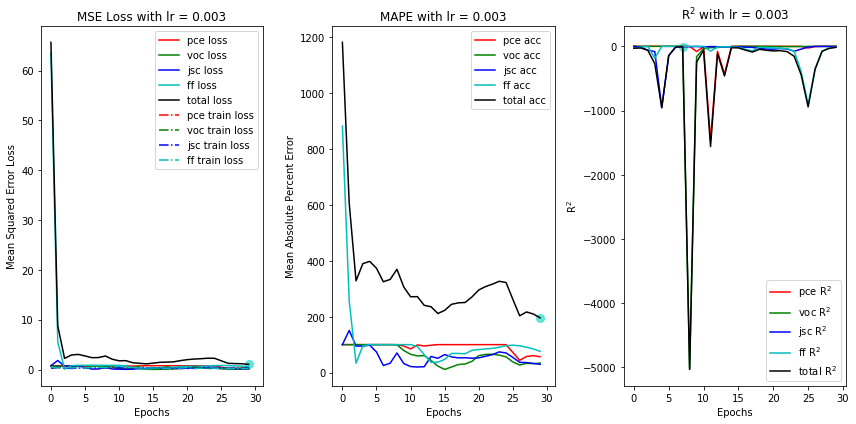

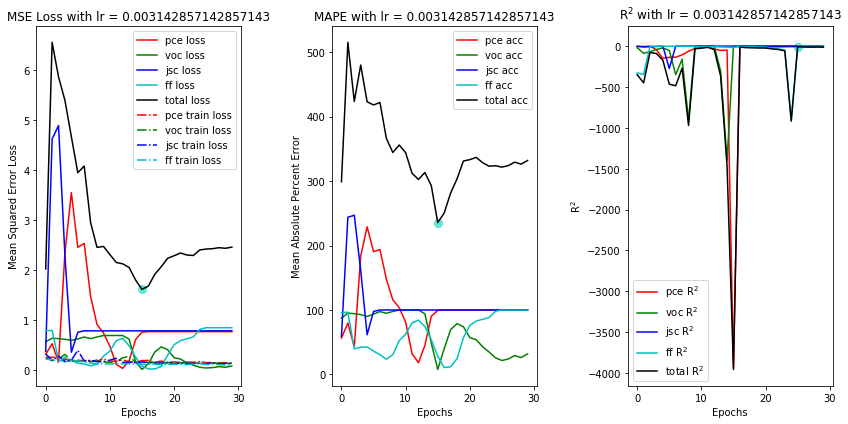

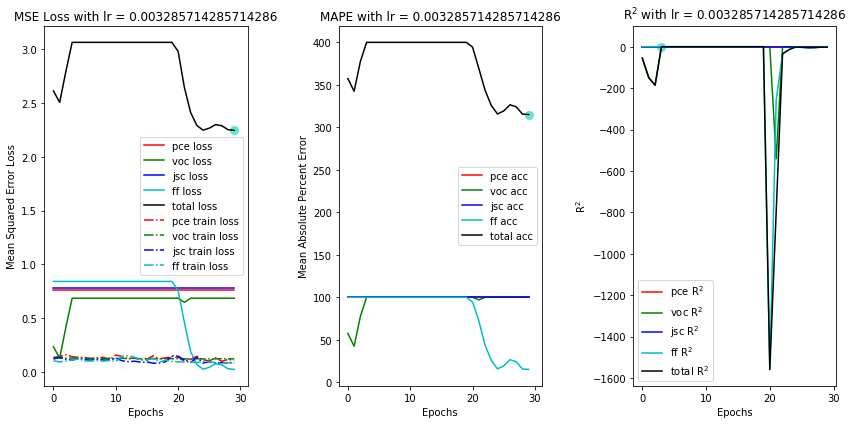

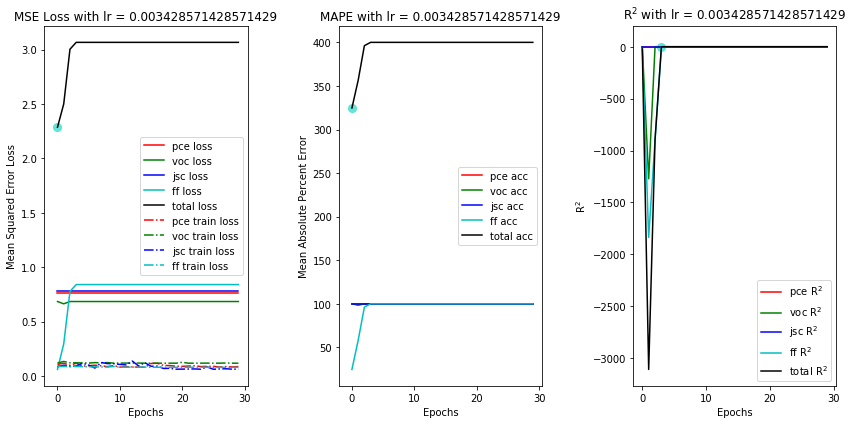

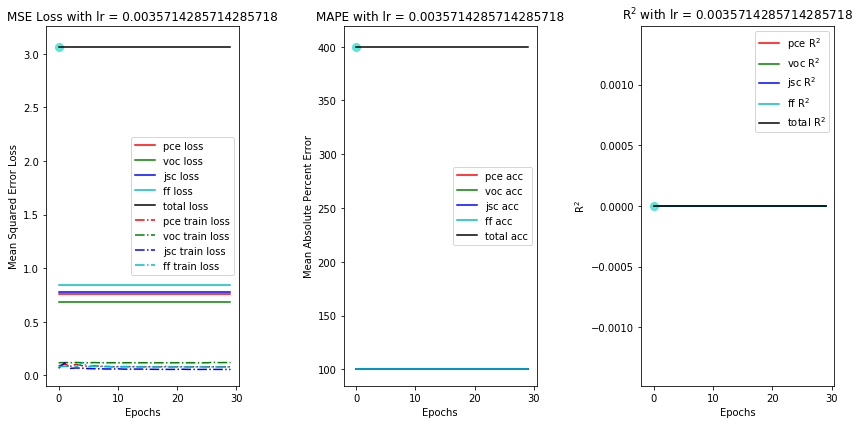

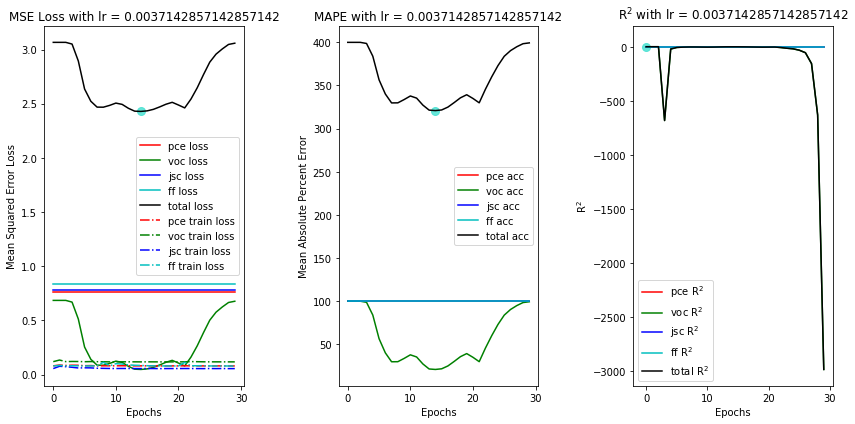

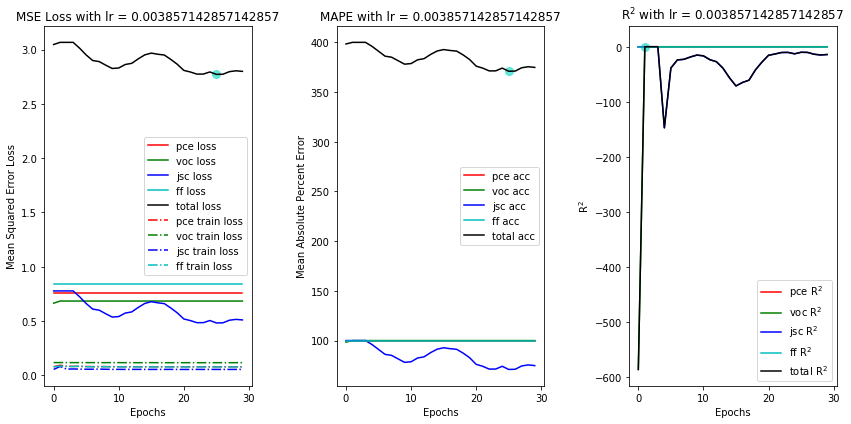

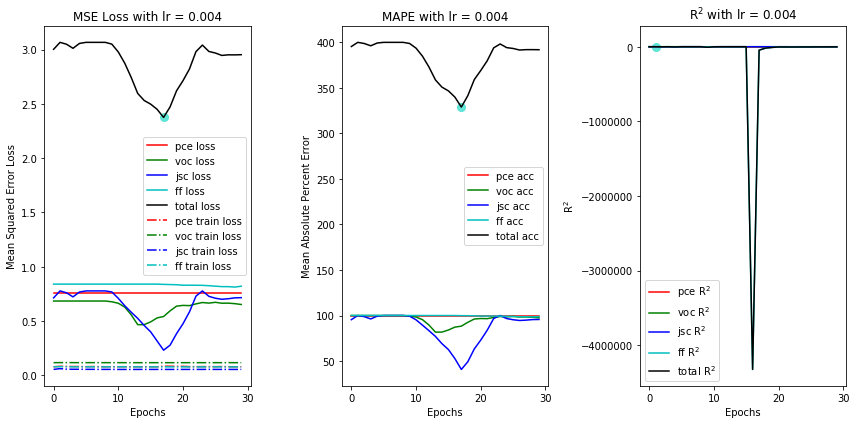

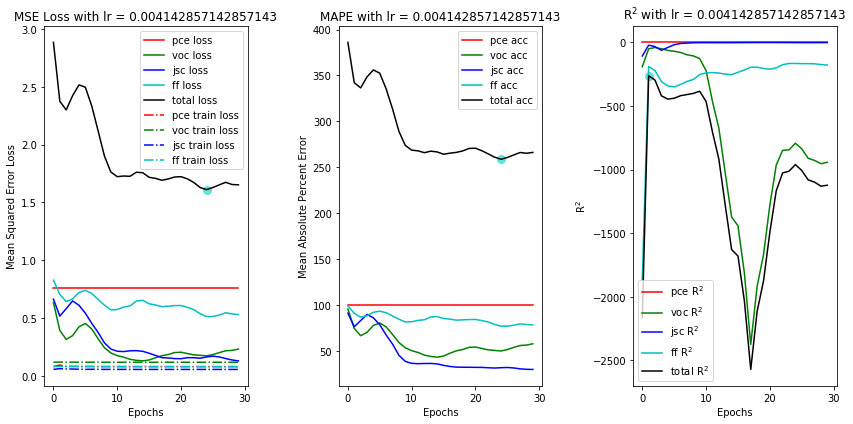

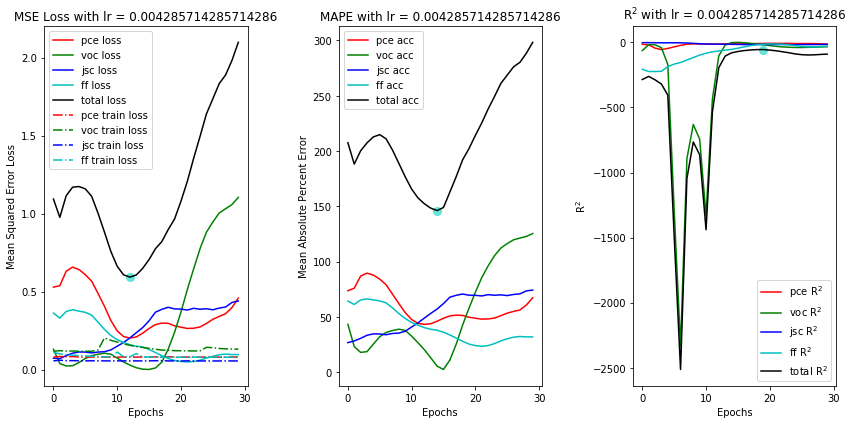

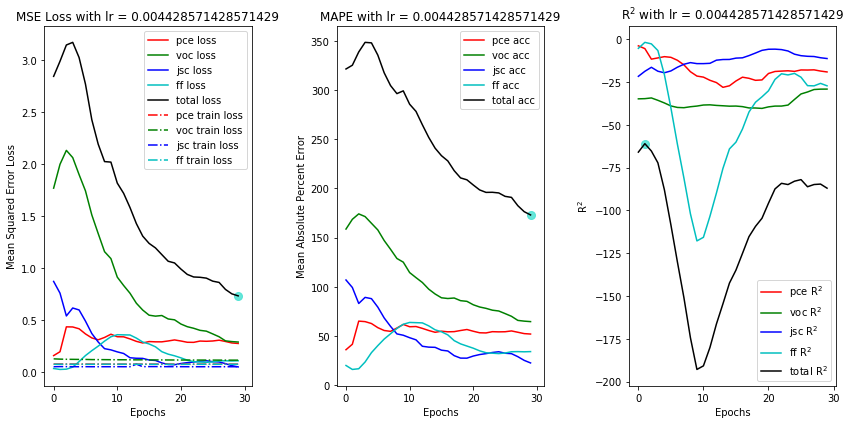

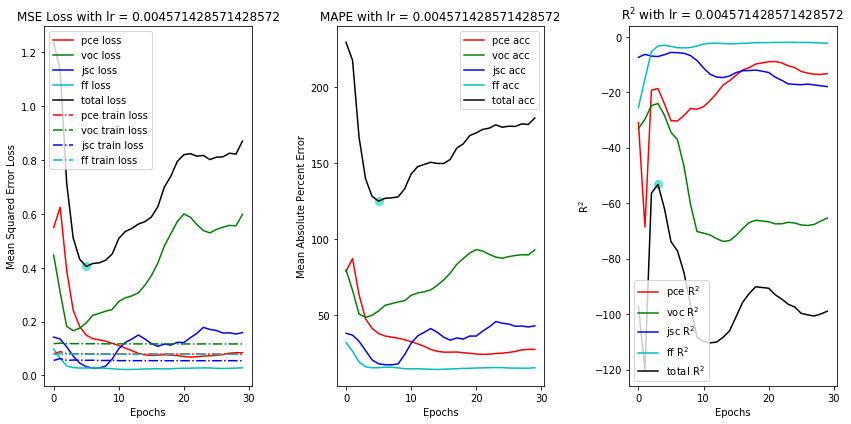

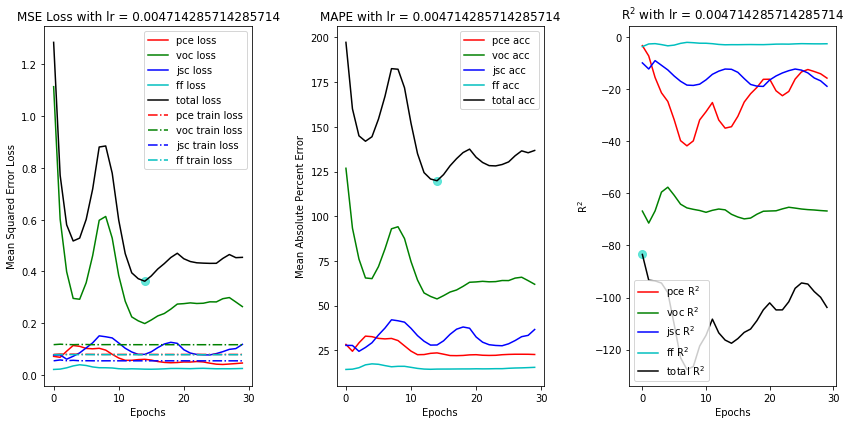

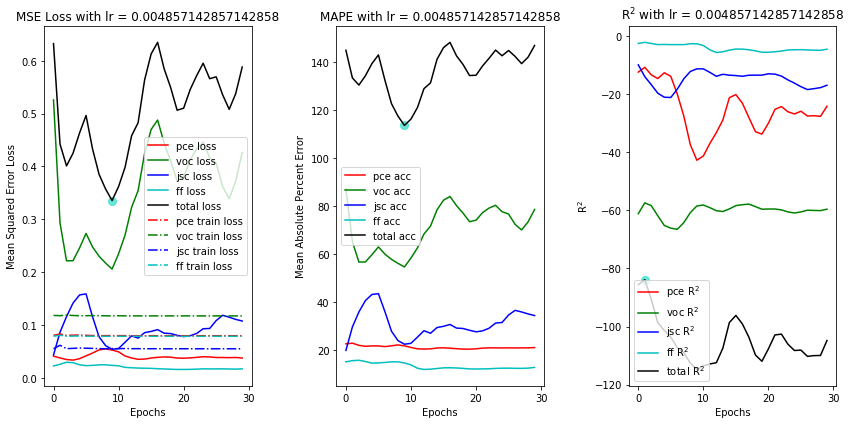

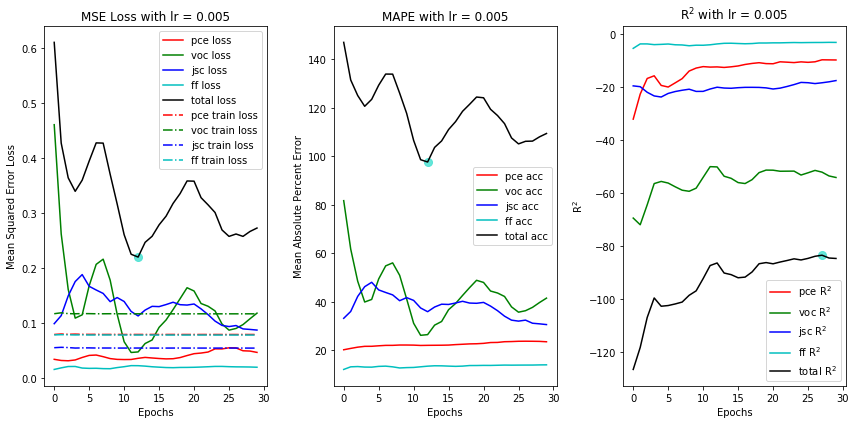

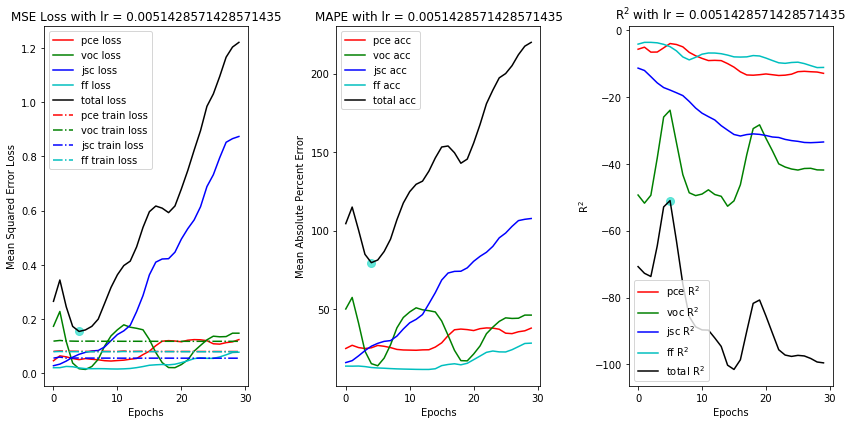

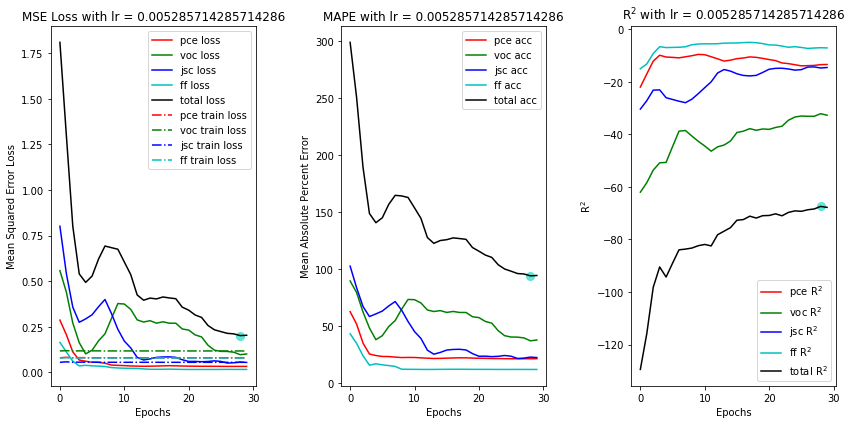

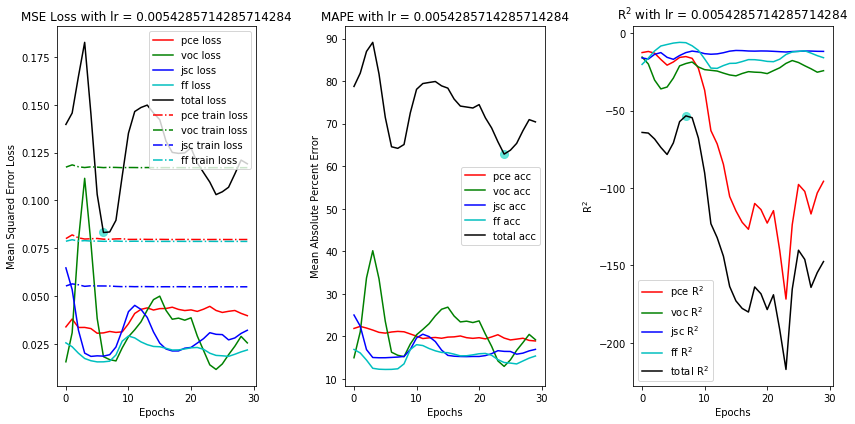

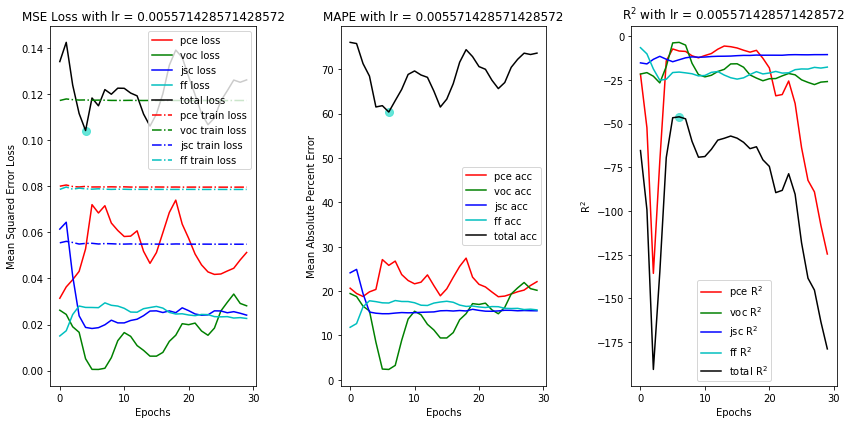

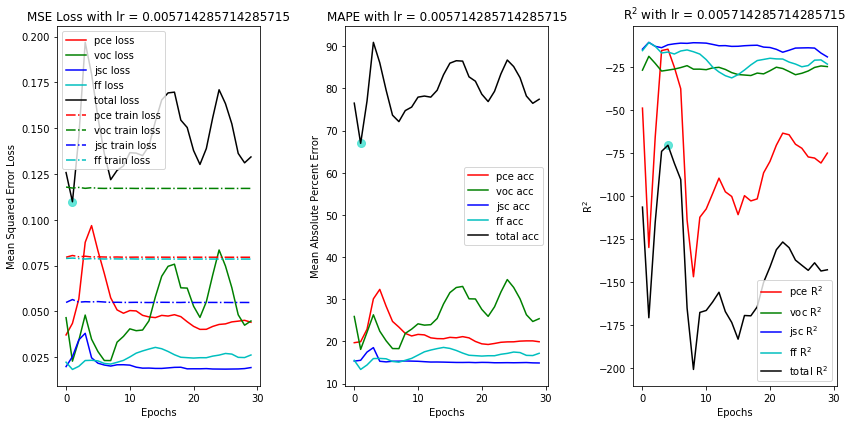

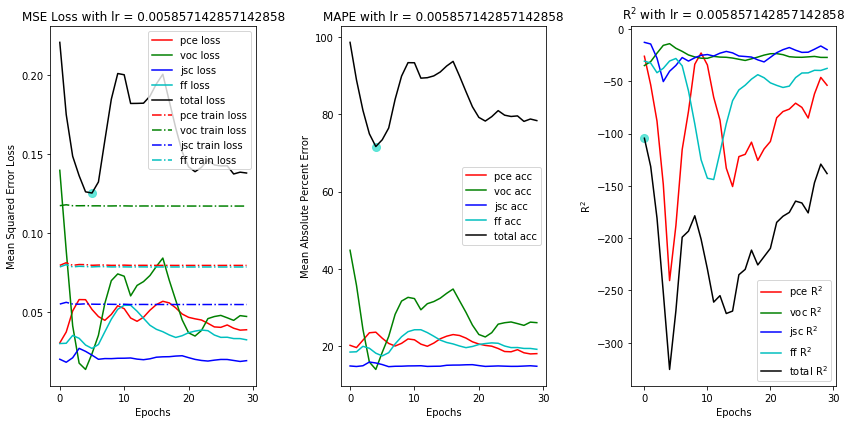

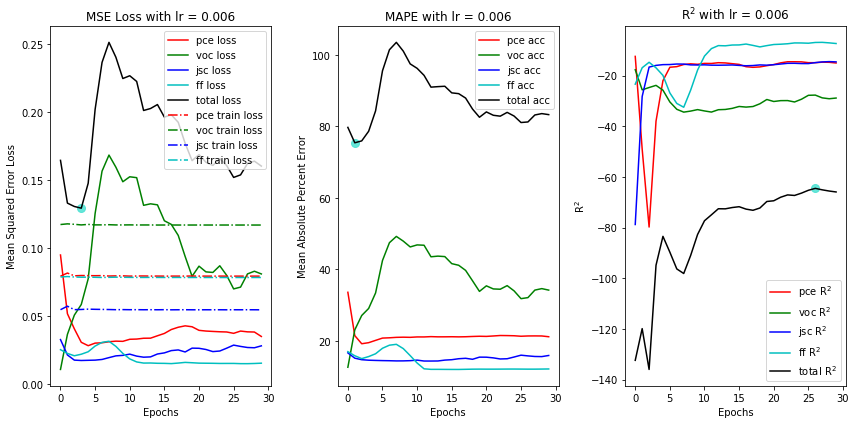

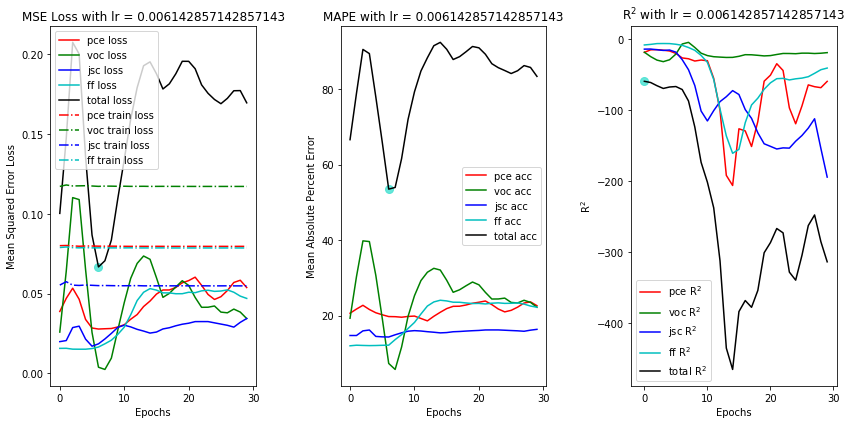

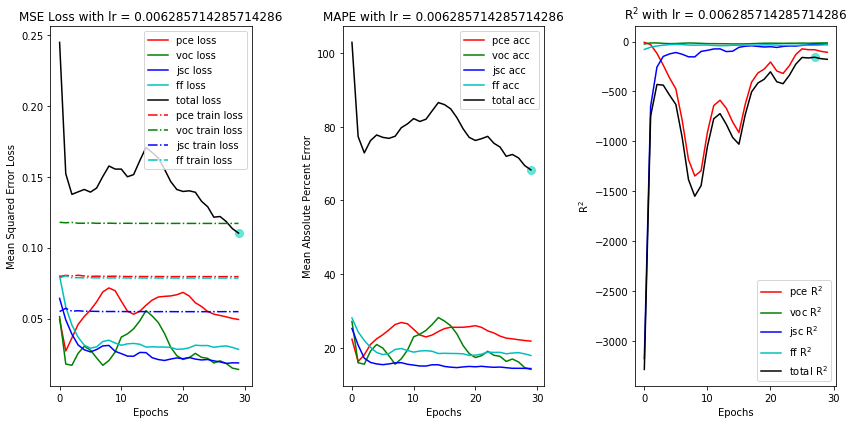

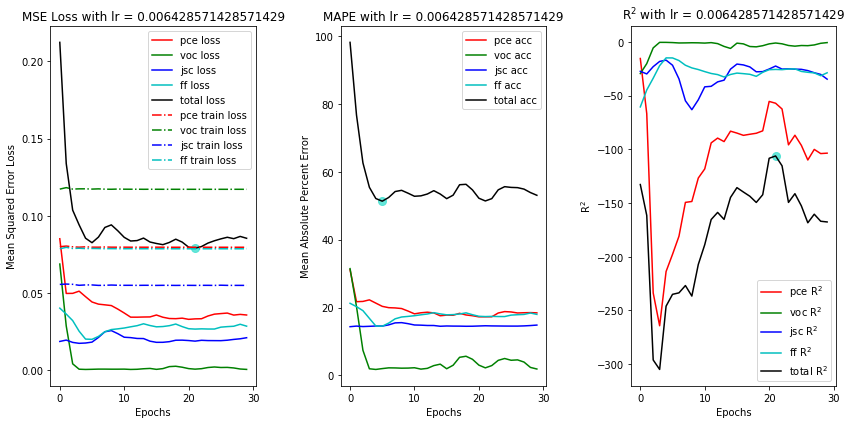

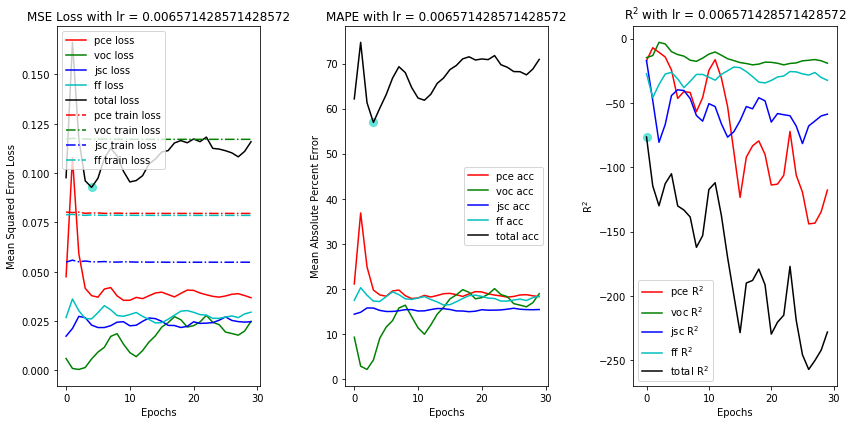

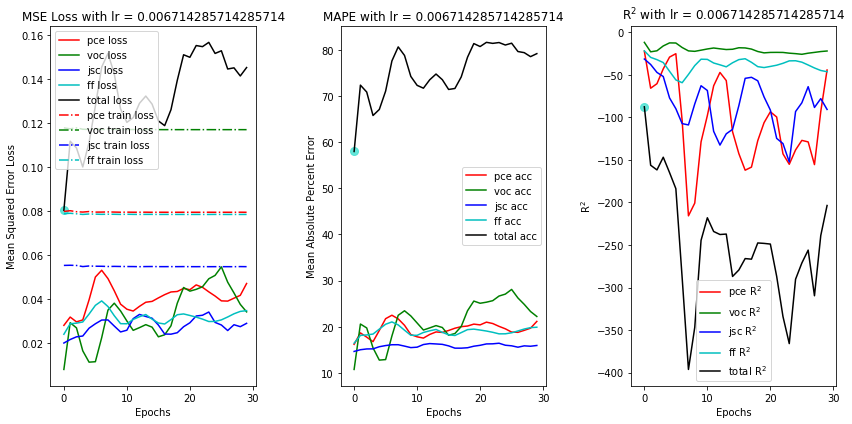

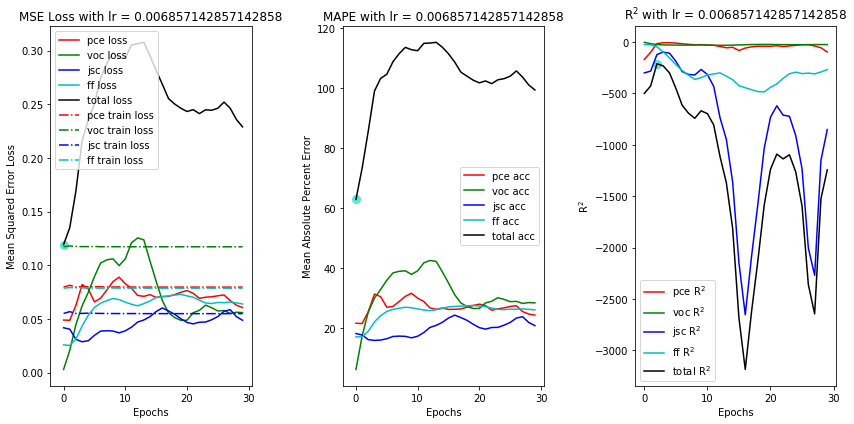

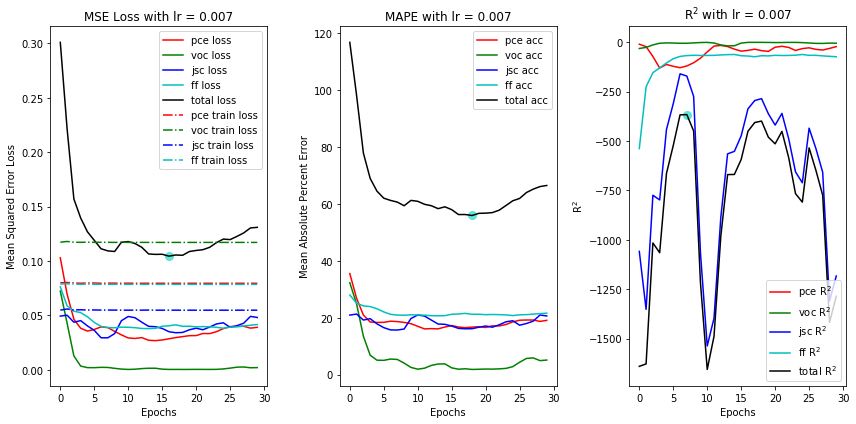

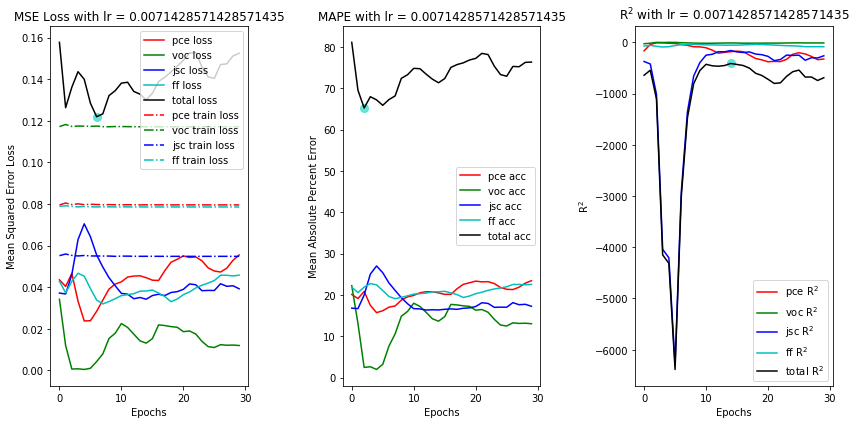

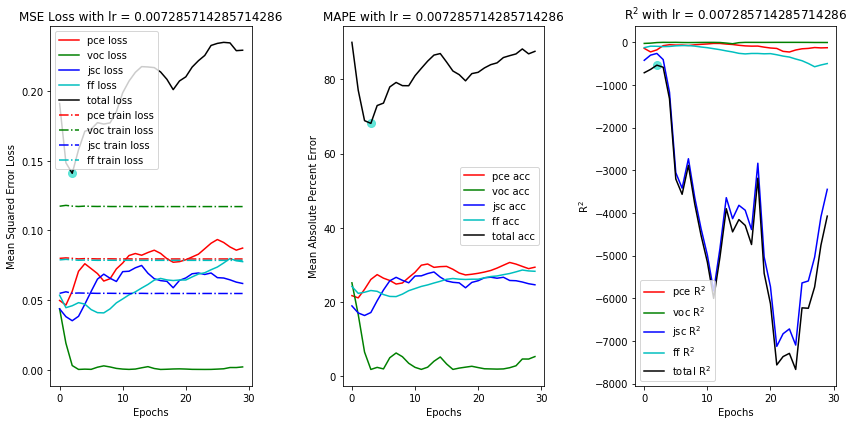

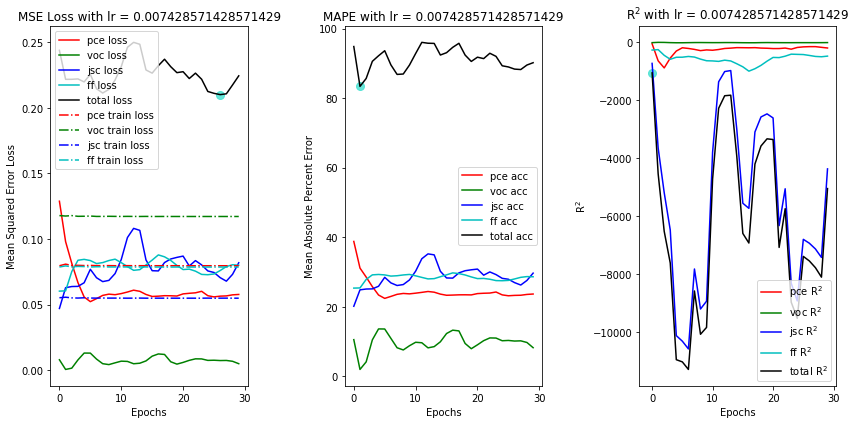

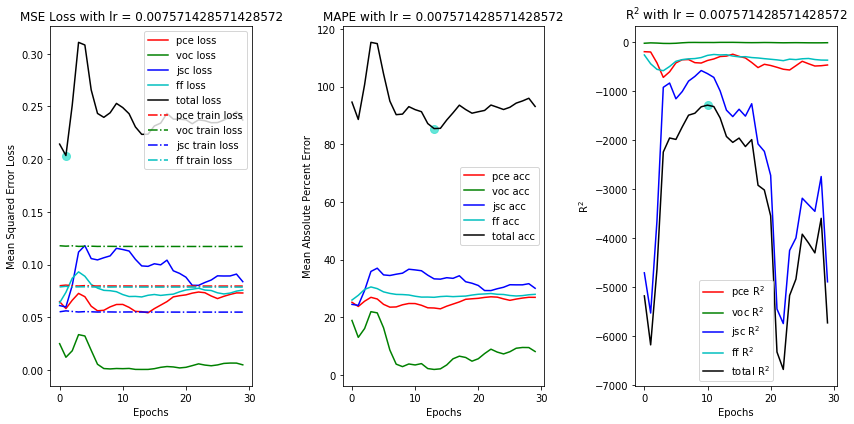

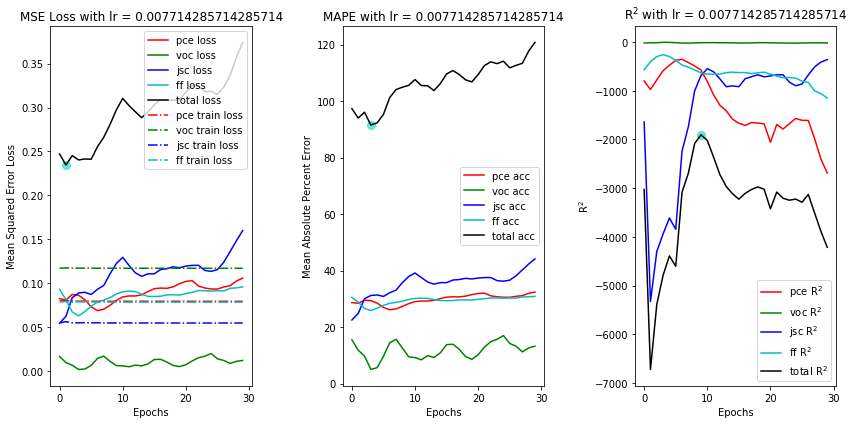

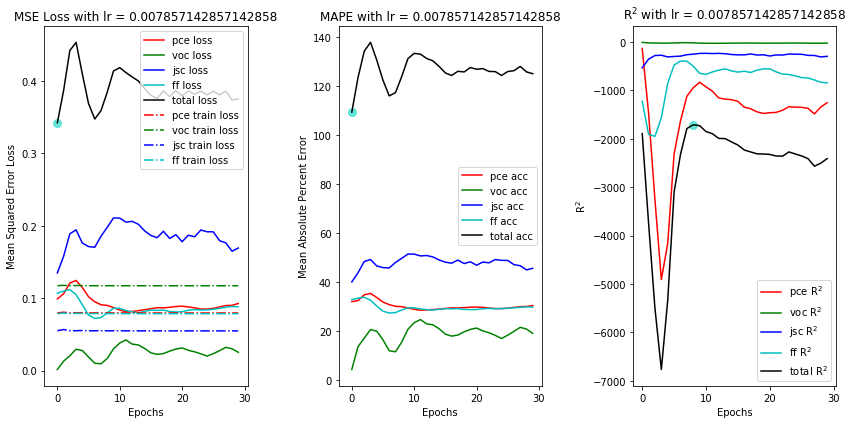

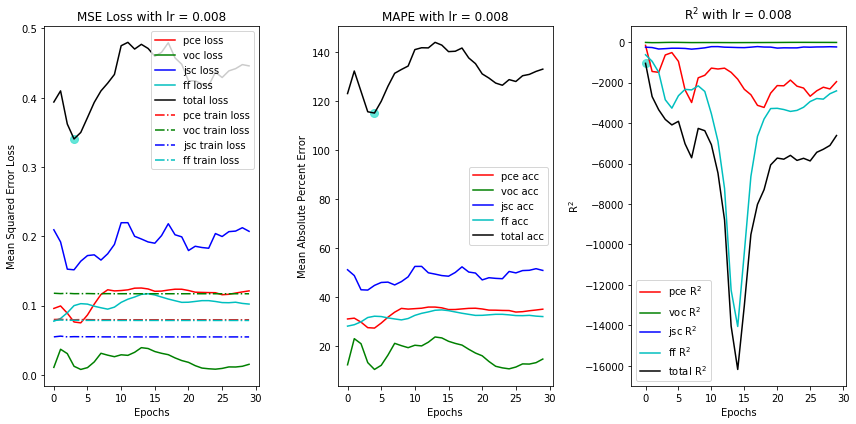

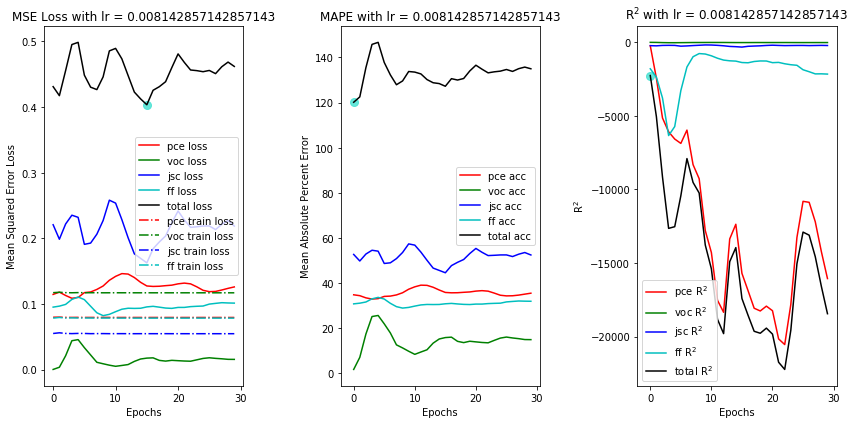

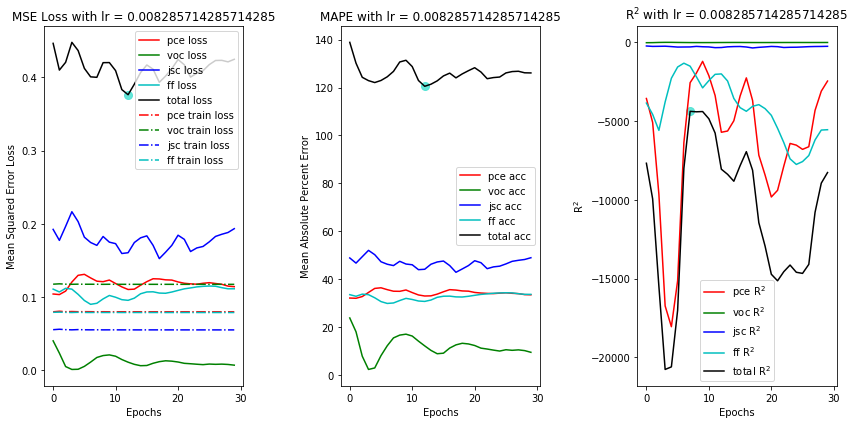

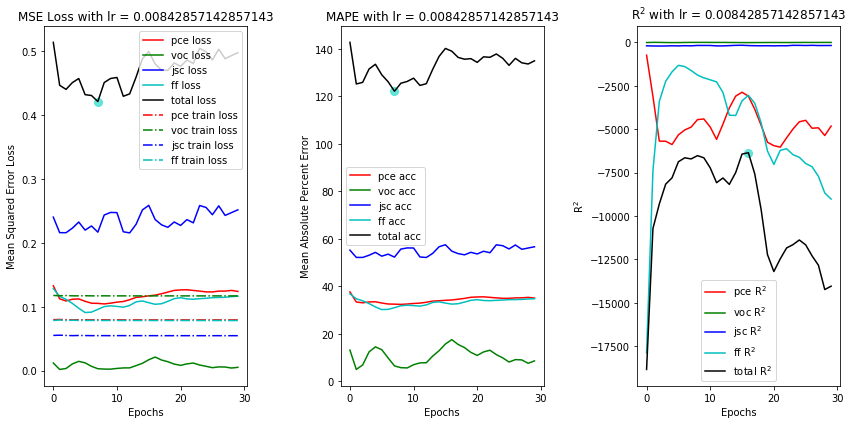

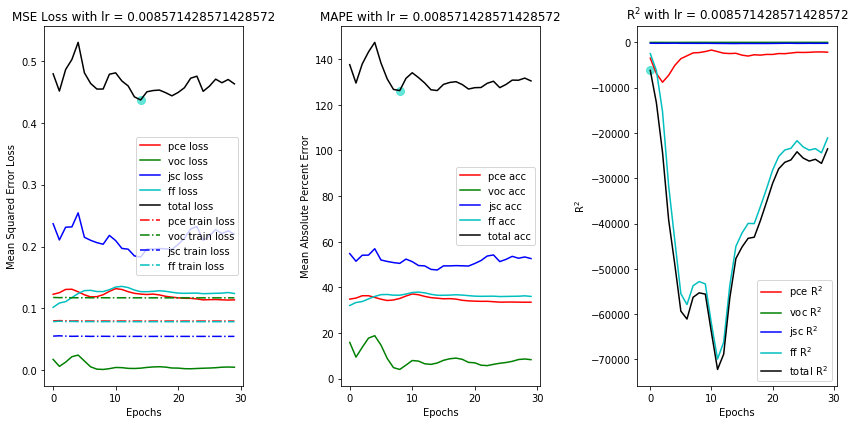

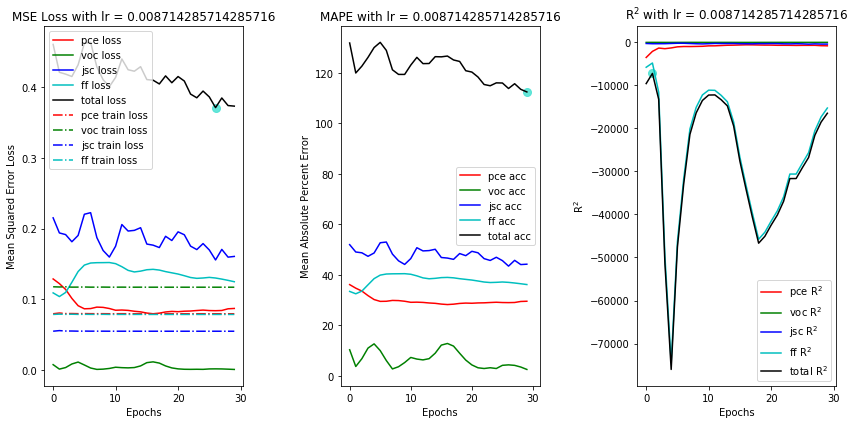

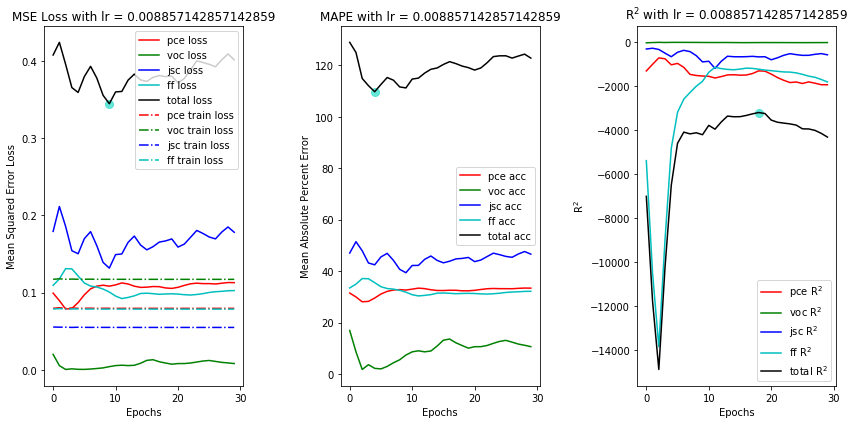

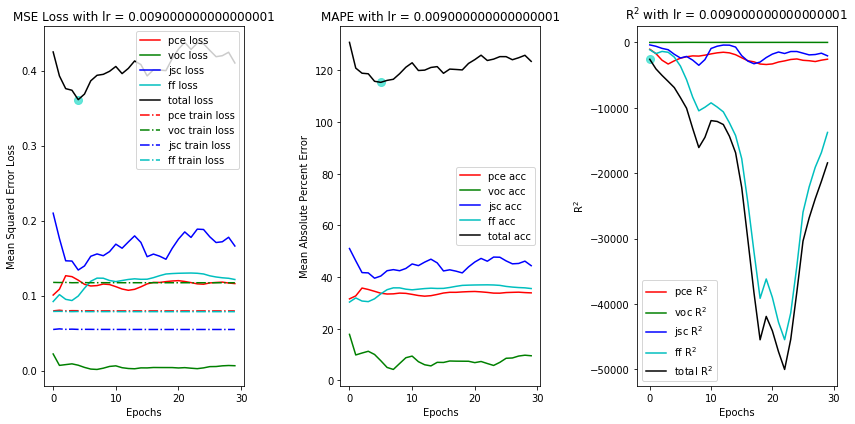

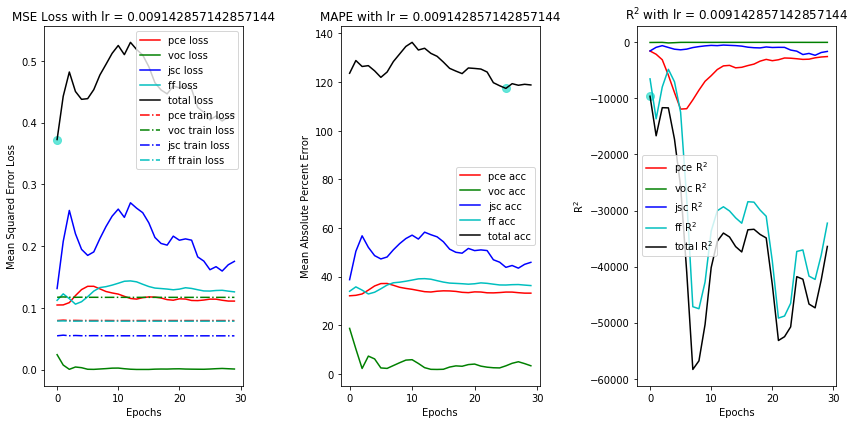

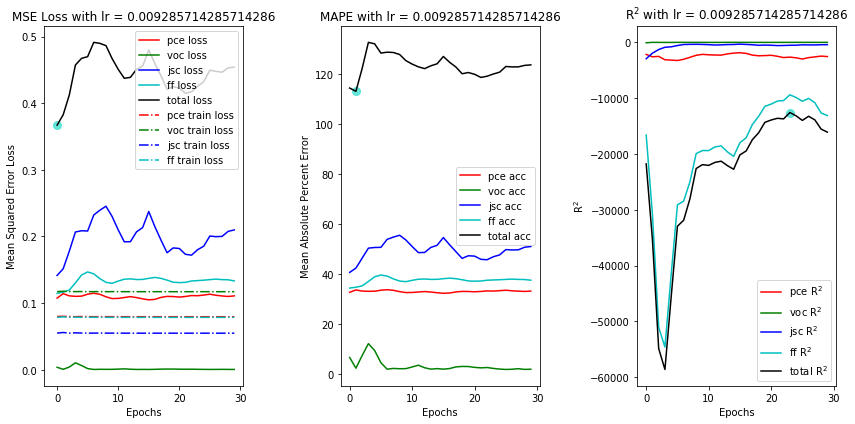

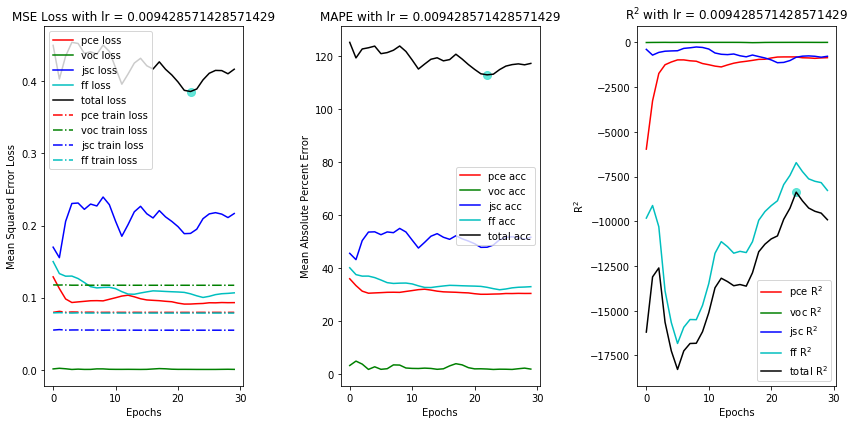

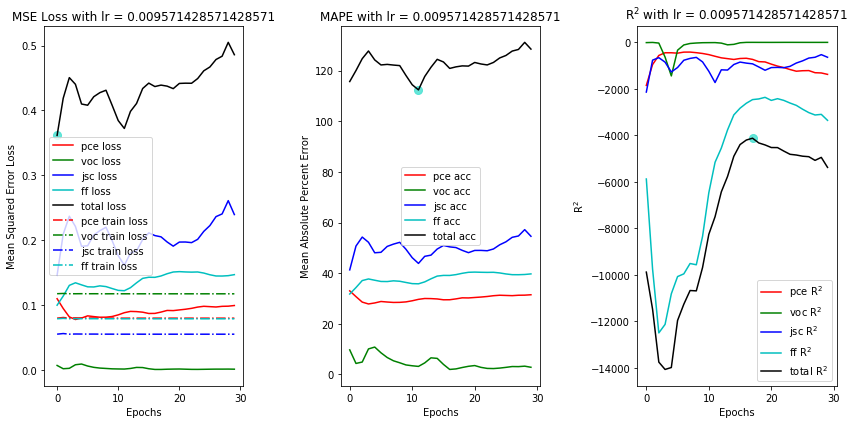

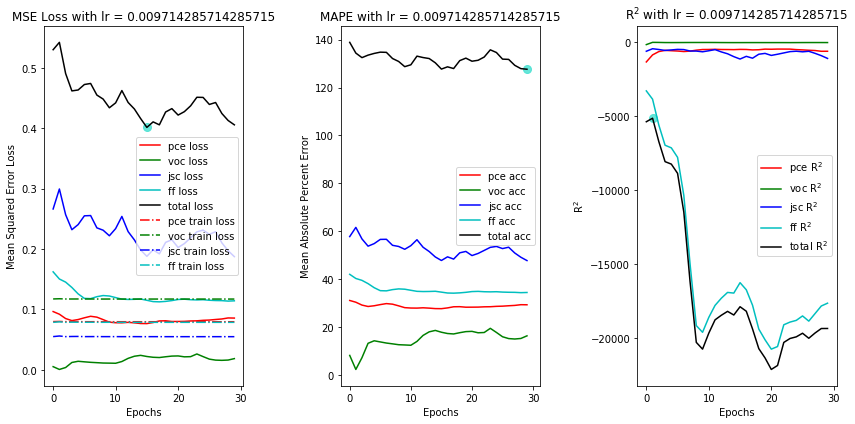

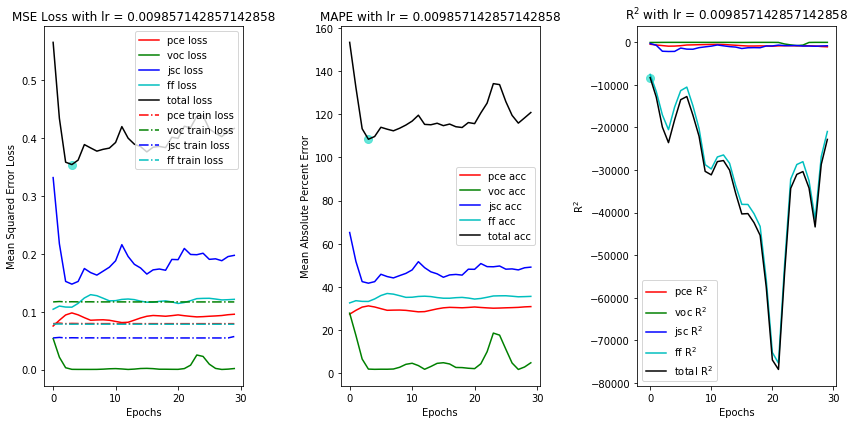

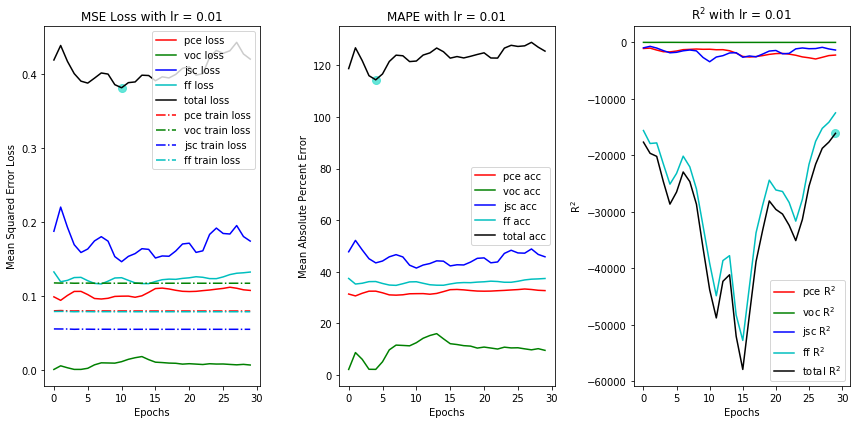

In [29]:
for key, fit_dict in data.items():
    plot_fit_results(fit_dict)

In [68]:
def best_fit_lrs(fit_dict):
    """
    Function that sorts through hyperparameter optimization results dictionaries and collects
    the 5 best learning rates and epochs.
    """
    best_params = {}
    
    #initialize variables with poor values
    lowest_loss = 200
    lowest_mape = 200
    highest_r2 = -200
    
    #for each lr fit, collect best values
    best_losses = []
    best_accs = []
    best_r2s = []
    
    for key, fit in fit_dict.items():
        
        loss_ep = fit['best_loss_epoch']
#         acc_ep = fit['best_acc_epoch']
#         r2_ep = fit['best_r2_epoch']
        
        #these all need to come from the same epoch for parameter selection
        best_losses.append(fit['test_losses'][loss_ep])
        best_accs.append(fit['test_accs'][loss_ep])
        best_r2s.append(fit['test_r2s'][loss_ep])
        
    return

def plot_best_fit_lrs(fit_dict):
    """
    A function that plots the best loss, accuracy, and r2 of a lr fit series. Note
    that the epoch shown is loss's best epoch, which many not correspond to the best
    epoch for accuracy or r2.
    """
    
    #for each lr fit, collect best values
    lrs = []
    best_losses = []
    best_accs = []
    best_r2s = []
    
    for key, fit in fit_dict.items():
        lrs.append(fit['lr'])
        
        loss_ep = fit['best_loss_epoch']
        acc_ep = fit['best_acc_epoch']
        r2_ep = fit['best_r2_epoch']
        
        #these will all need to come from the same epoch during parameter selection
        best_losses.append(fit['test_losses'][loss_ep])
        best_accs.append(fit['test_accs'][acc_ep])
        best_r2s.append(fit['test_r2s'][r2_ep])
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(lrs, best_losses, c = 'r')
    ax1.scatter(lrs[best_losses.index(min(best_losses))], min(best_losses), s = 64, alpha = 0.8, c = 'turquoise')
    ax1.set_xlabel('Learning Rates')
    ax1.set_ylabel('Mean Squared Error Loss')
    ax1.set_title(f'MSE Loss with lr')
    
    ax2.plot(lrs, best_accs, c = 'r')
    ax2.scatter(lrs[best_accs.index(min(best_accs))], min(best_accs), s = 64, alpha = 0.8, c = 'turquoise')
    ax2.set_xlabel('Learning Rates')
    ax2.set_ylabel('Mean Absolute Percent Error')
    ax2.set_title(f'MAPE with lr')
    
    ax3.plot(lrs, best_r2s, c = 'r')
    ax3.scatter(lrs[best_r2s.index(max(best_r2s))], max(best_r2s), s = 64, alpha = 0.8, c = 'turquoise')
    ax3.set_xlabel('Learning Rates')
    ax3.set_ylabel('R$^2$')
    ax3.set_title(f'R$^2$ with lr')
    
    plt.tight_layout()
    plt.show()

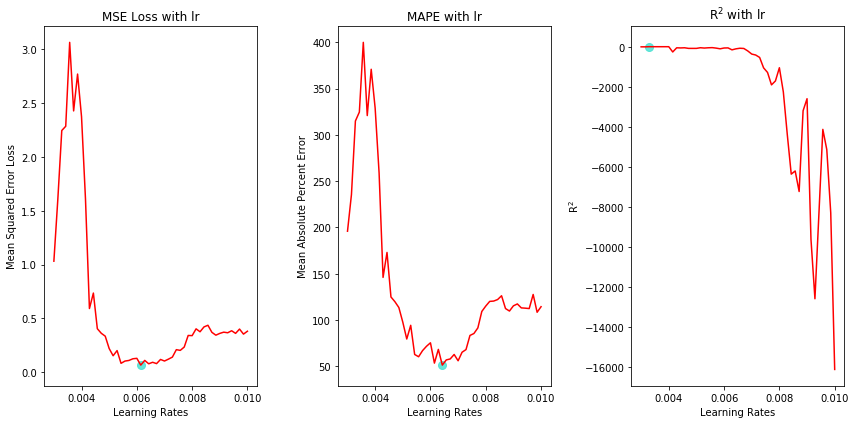

In [69]:
plot_best_fit_lrs(data)

In [14]:
avg_acc = []
for p, v, j, f in zip(pce_test_epoch_accuracies, voc_test_epoch_accuracies,
                      jsc_test_epoch_accuracies, ff_test_epoch_accuracies):
    
    acc = (p+v+j+f)/4
    avg_acc.append(acc)
    
fig, ax = plt.subplots()
plt.plot(epochs, avg_acc)
plt.title('Average MAPE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute % Error')
plt.show()

In [11]:
potential_models = avg_acc[:45]

min_mape = min(potential_models)

best_acc_indx = []
for acc in potential_models:
    if acc == min_mape:
        best_acc_indx.append(potential_models.index(acc))
    else:
        pass

In [12]:
if best_acc_indx[0] < 10:
    epoch = f'0{best_acc_indx[0]}'
else:
    epoch = f'{best_acc_indx[0]}'

print(epoch)

best_model_path = save_dir + model_name + '_epoch' + epoch + '.pt'
best_model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)

best_model, best_optimizer = nuts.load_trained_model(best_model_path, best_model, optimizer)

44


In [13]:
%autoreload

best_model.eval()

with torch.no_grad():
    for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
        inputs = inputs.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)

        PCE_out, Voc_out, Jsc_out, FF_out = best_model(inputs)
        

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(PCE_out, pce_labels)
pce_r2 = r2_score(PCE_out, pce_labels)
pce_mape = mape.forward(PCE_out, pce_labels)

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(Voc_out, voc_labels)
voc_r2 = r2_score(Voc_out, voc_labels)
voc_mape = mape.forward(Voc_out, voc_labels)

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(Jsc_out, jsc_labels)
jsc_r2 = r2_score(Jsc_out, jsc_labels)
jsc_mape = mape.forward(Jsc_out, jsc_labels)

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(FF_out, ff_labels)
ff_r2 = r2_score(FF_out, ff_labels)
ff_mape = mape.forward(FF_out, ff_labels)

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

mse = 0.19899603724479675, mape = tensor([42.4352]), r2 = -3.2588184649885967
mse = 0.01759914495050907, mape = tensor([14.5273]), r2 = 0.21906688694331422
mse = 0.08423228561878204, mape = tensor([28.9978]), r2 = -2.736029657752177
mse = 0.15580657124519348, mape = tensor([40.9560]), r2 = -5.974962394590461


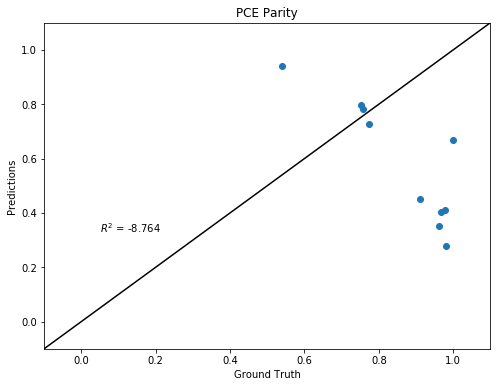

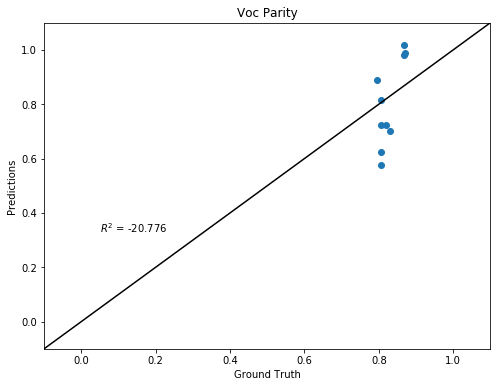

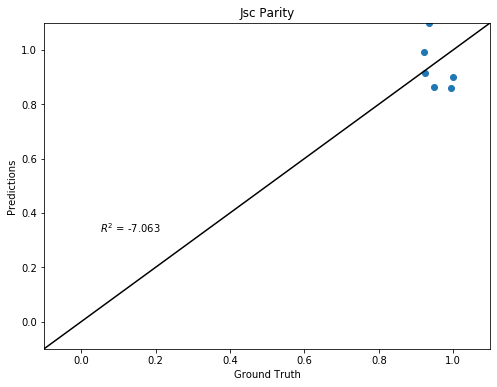

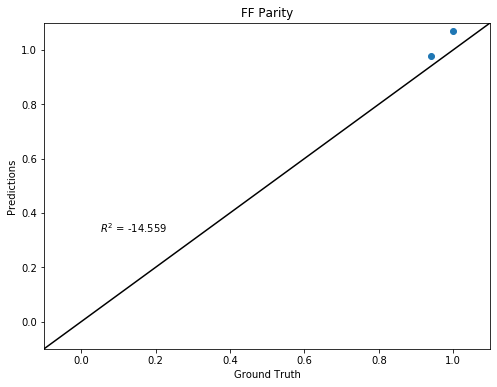

In [14]:
%autoreload

nuts.plot_OPV_parity(pce_labels, PCE_out, voc_labels, Voc_out, jsc_labels, Jsc_out, ff_labels, FF_out)